# Group 7 
## Project 4 - Predicting bankruptcy from financial indicators 

### Group members：
| NO  |        NAME      | Matriculation No|
|-----|------------------|-----------------|
|  1  |   Kun Lin Tsai   |       437791    |
|  2  | Sushmitha Prabhu |       427331    |
|  3  |Swapnali Sonkusale|       429016    |

## 1. Import necessary libraries

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import imblearn 
from imblearn.over_sampling import SMOTE # Oversampling
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS, ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed 
from sklearn.metrics import recall_score,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score

### 1.2 Functions

In [10]:
# Method for outlier detection via Inter-quartile range method: 
def outlier_detection_IQR(x, scale):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - scale * IQR 
    upper = Q3 + scale * IQR  
    outliers = ((x<lower)| (x>upper)).sum()
    total_length = len(x.index)
    percent_outlier = (outliers * 100 / total_length).round(3)
    print(x.name, "\tTotal outliers is: ", outliers,"\t", "\t Percentage Outliers: ", percent_outlier )    

In [11]:
# Method for outlier detection via Isolation forest method: 
def outlier_detection_IF(df_input):
    model = IsolationForest(n_estimators = 50, max_samples='auto', contamination=float(0.1), max_features=1.0)
    model.fit(df_input)
    df_input['anomaly']=model.predict(df_input)
    anomaly=df_input.loc[df_input['anomaly']==-1]
    anomaly_index=list(anomaly.index)
    print("\f The total number of anomalities in data is ", len(anomaly))
    return df_input  #anomaly

In [12]:
# Outlier treatment via Capping upper and lower 
def outlier_treatment_Capping(attr,threshold,dataframe):
    Q1 = attr.quantile(0.25)
    Q2 = attr.quantile(0.50)
    Q3 = attr.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR 
    upper = Q3 + threshold * IQR 
    if (attr.name != 'class'):
        dataframe[attr.name] = np.where((dataframe[attr.name]>upper), upper , dataframe[attr.name])
        dataframe[attr.name] = np.where((dataframe[attr.name]<lower), lower , dataframe[attr.name])
    return dataframe

In [13]:
# Method to perform imputation on data frame. Pass data frame and the strategy via which imputation is to be carried out.
# Outlier treatment for median
def Imputation(data, approach):
    imputer = SimpleImputer(strategy = approach, missing_values = np.nan)
    imputer = imputer.fit(data)
    data_return = pd.DataFrame(imputer.transform(data.loc[:,:]), 
                             columns = data.columns)
  #  print("\f Imputed data via strategy: ", approach )
    return data_return

In [14]:
# Outlier treatment for Isoaltion forest detected outliers by deleting anomaly rows
def outlier_treatment_IF(dataframe):
    dataframe.drop(dataframe[dataframe.anomaly == -1].index, inplace=True)
    return dataframe

In [15]:
# Outlier treatment Replacing Outliers with Median Values
def outlier_treatment_IQR(attr,threshold,dataframe):
    Q1 = attr.quantile(0.25)
    Q2 = attr.quantile(0.50)
    Q3 = attr.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR 
    upper = Q3 + threshold * IQR 
    if (attr.name != 'class'):
        dataframe[attr.name] = np.where((dataframe[attr.name]>upper)|(dataframe[attr.name]<lower), Q2 , dataframe[attr.name])
    return dataframe    

In [16]:
# Creating training set and test set for input dataframe
def preprocessing_TTS(dataframe):
    x = dataframe.iloc[:, 0: len(dataframe.columns)-1]
    y = dataframe.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=42)
    
    return x_train, x_test, y_train, y_test

In [17]:
# Random forest feature selection based on the weights and gives best subset of features 
def RF_FeatureSelector(x_train, x_test, y_train, y_test):
    data_results = []

    for weight in range(1,20):
        forest = RandomForestClassifier(n_estimators = 100, max_features = 40, max_depth = 40, class_weight={0:1,1:weight}, n_jobs = -1, random_state = 42)
        forest.fit(x_train, y_train)
        model = SelectFromModel(forest, prefit=True)
        recall_ = recall_score(y_test, forest.predict(x_test), average='macro')
        names = model.get_support()
        data_results.append([weight, model.transform(x_train).shape[1], recall_.round(decimals=2), x_train.columns[names].values])
    
    return data_results

In [18]:
def plot_confusion_matrix(confusion_mat, model_name, cmap):
    ax = sns.heatmap(confusion_mat, annot=True, 
                     annot_kws={'size':18,'weight':'normal'},
                     fmt='.20g', 
                     cmap=cmap, 
                     cbar_kws={'shrink':1},
                     linewidths=2)
    plt.title(model_name)
    plt.ylabel('Actual')
    plt.xlabel('Predict ')
    cbar = ax.collections[0].colorbar
    plt.show()

In [19]:
def plot_AUC_curve(result_table):

    fig = plt.figure(figsize=(8,6))
    
    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

## 2. Read data file

In [20]:
#sets the maximum number of columns and rows displayed when a frame is pretty-printed
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [21]:
df = pd.read_csv('bankruptcy.csv')

In [22]:
#Replace the categorical column (class) values into binary
df_binary_class = df.copy(deep = True)
# Replace by class 0 and 1 values
df_binary_class['class']=pd.Categorical(df_binary_class['class'].replace({"b'0'" : 0, "b'1'":1}))
# Change the class variable from categorical to integer
df_binary_class['class']= pd.Categorical(df_binary_class['class']).codes
df_binary_class.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,10503.000000,10485.000000,10460.000000,10503.000000,1.049500e+04,10489.000000,10489.000000,10503.000000,10460.000000,10460.000000,9696.000000,10503.000000,10460.000000,10276.000000,10503.000000,10489.000000,9.788000e+03,10275.000000,10503.000000,10460.000000,10460.000000,1.040200e+04,10485.000000,10489.000000,10503.000000,10503.000000,5767.000000,10503.000000,10460.000000,10485.000000,10301.000000,10460.000000,10460.000000,10460.000000,9912.000000,10485.000000,1.041700e+04,10503.000000,10460.000000,10489.000000,10503.000000,10417.000000,10275.000000,10275.000000,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,0.086764,2.411266,0.376563,0.065634,3.004332e+03,2.729654,20.511539,0.070739,-0.170778,68.448531,4.670725,0.075676,-0.176466,0.211936,0.196153,2.580730,1.185945e+03,6.092884,3.921179,0.459346,-0.177084,1.171670e+03,8.419887,5.398356,0.071075,1.981250,102.697692,0.465510,-0.076355,2.381026,28.707178,-0.141671,195.389286,126.940260,17.451297,8.978029,5.424888e+02,0.004834,-0.217844,8.686024,0.497135,11.244158,5.725829,6.708568,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800,0.047129
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,0.655407,111.459642,49.675550,0.651151,1.091981e+05,110.233475,721.812766,0.835328,11.210201,1083.699904,305.897238,0.581734,11.149274,2.093845,6.742161,108.823993,3.469123e+04,94.713753,0.840528,71.755042,11.157003,6.841270e+04,37.696764,69.035263,0.572124,2.630705,2469.447679,6.425362,8.079334,37.819839,2845.290346,10.787555,3303.309554,2766.505503,1720.342176,523.565601,3.126416e+04,0.629770,11.910935,522.528325,6.420885,851.867915,89.708042,93.511530,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-2.200900,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,0.009809,0.006183,0.020740,0.002131,1.865950e+02,0.060302,1.449200,0.002131,0.001648,14.253750,0.796673,0.000000,0.000556,0.014938,0.135695,0.055067,0.000000e+00,0.027178,3.393200,0.073850,0.004012,4.471900e+01,2.785900,0.367460,0.001730,1.043500,1.038600,0.426810,0.001557,0.053666,0.022026,0.000000,65.627250,34.214750,0.006157,0.602830,1.494100e+01,-0.048988,-0.036186,0.749370,0.177200,0.122470,0.667285,0.950435,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350,0.00

In [23]:
# Find top 20 columns with most null values
print(df_binary_class.isnull().sum().sort_values(ascending=False).head(20))      

Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr28     228
Attr53     228
Attr54     228
Attr64     228
Attr24     227
Attr41     202
Attr32     101
Attr47      86
Attr52      86
Attr30      43
Attr20      43
Attr49      43
Attr23      43
Attr56      43
Attr39      43
dtype: int64


<BarContainer object of 65 artists>

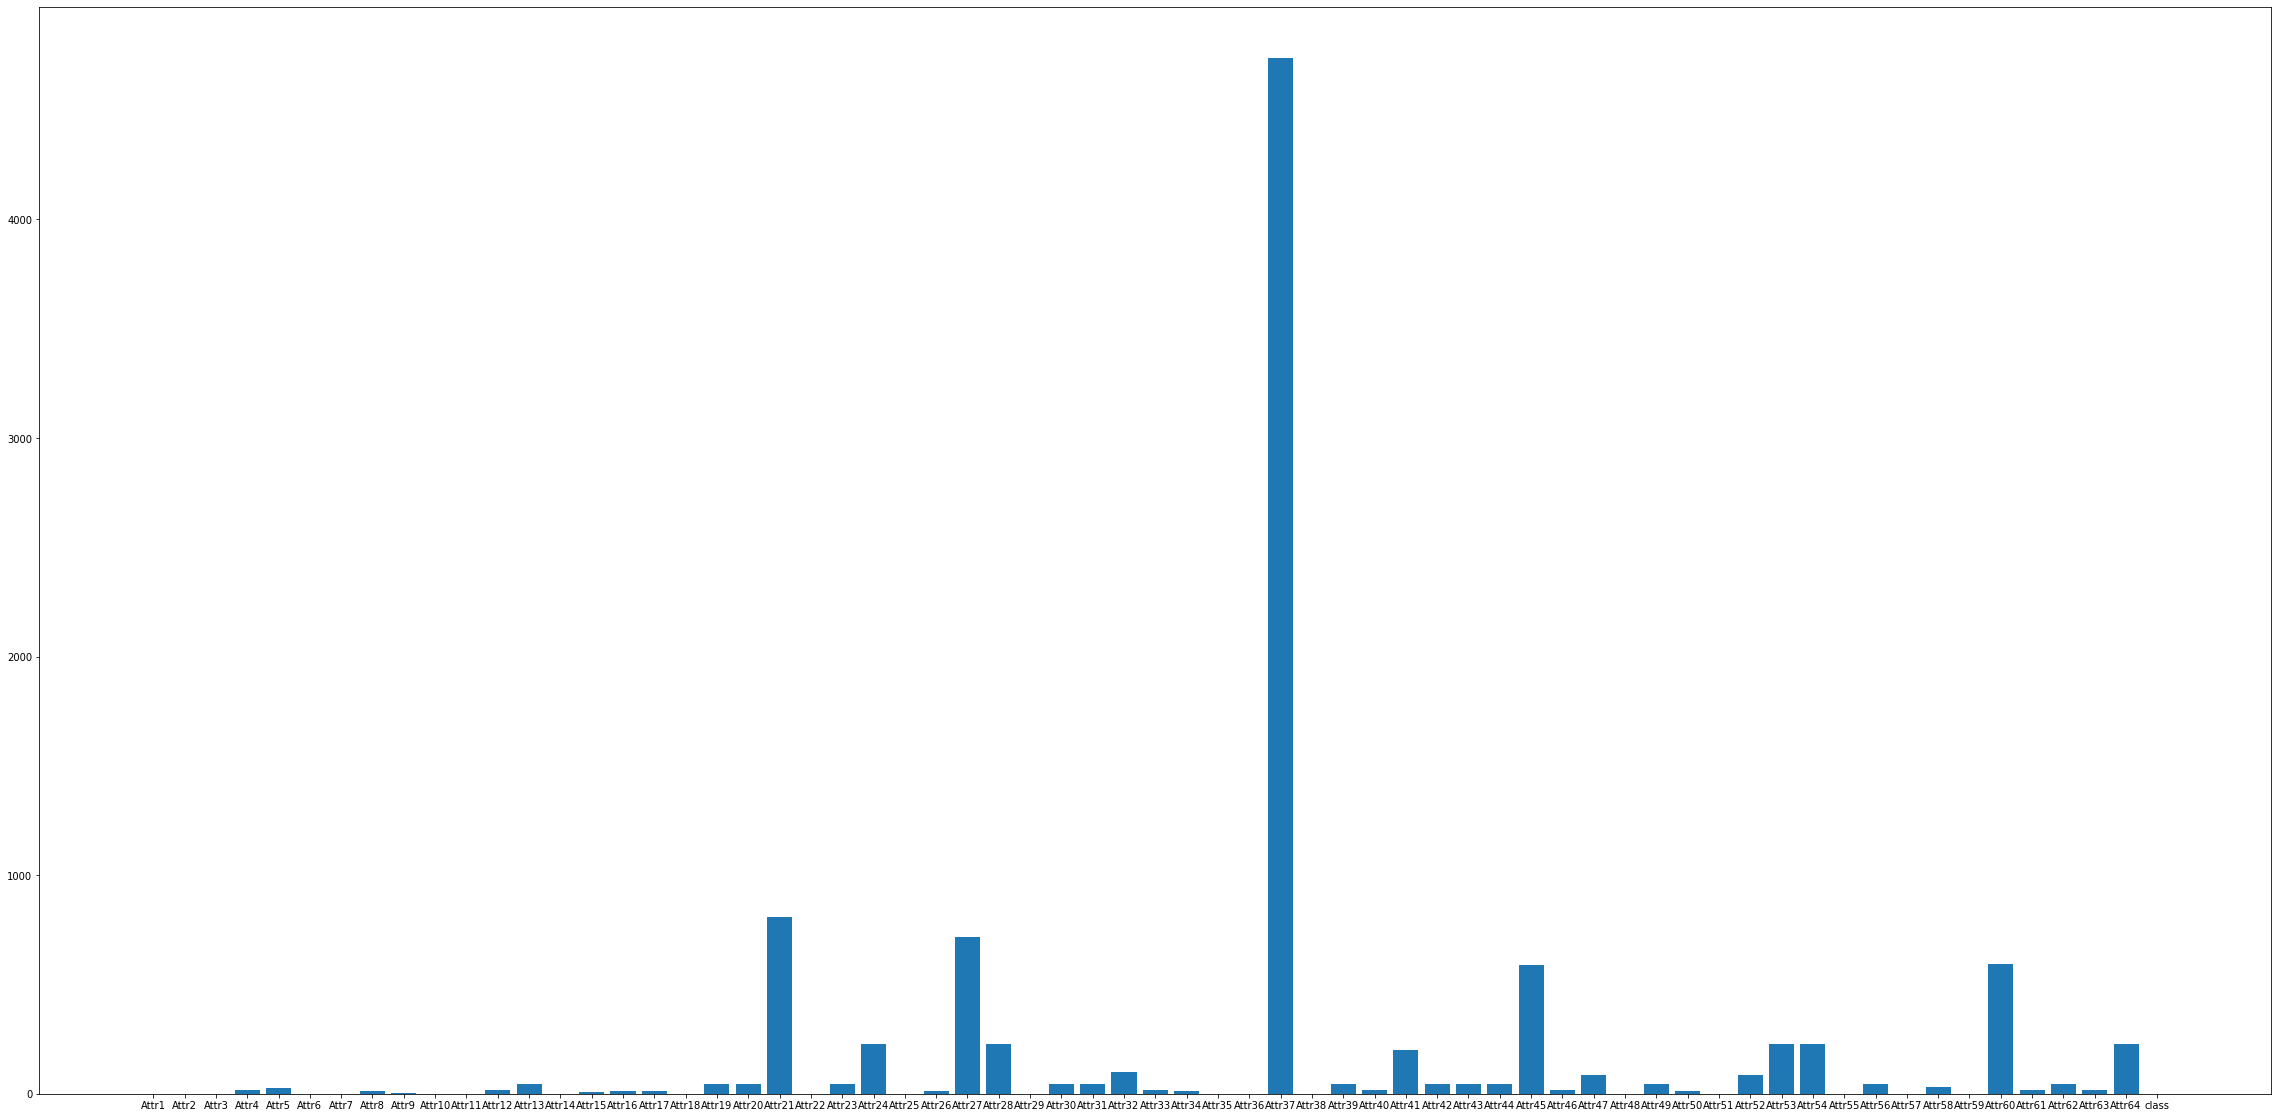

In [24]:
#replace the null values with 'nan'
df_binary_class = df_binary_class.replace('', np.nan)
nan_columns = []
nan_values = []
#count the number of  nan values in Dataset and plot a bargraph
for column in df_binary_class.columns:
    nan_columns.append(column)
    nan_values.append(df_binary_class[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

Column Attr37 contains the highest number of "Nan" values and data imputation on the column will nto be useful. Remove the column and plot the bar graph again

<BarContainer object of 64 artists>

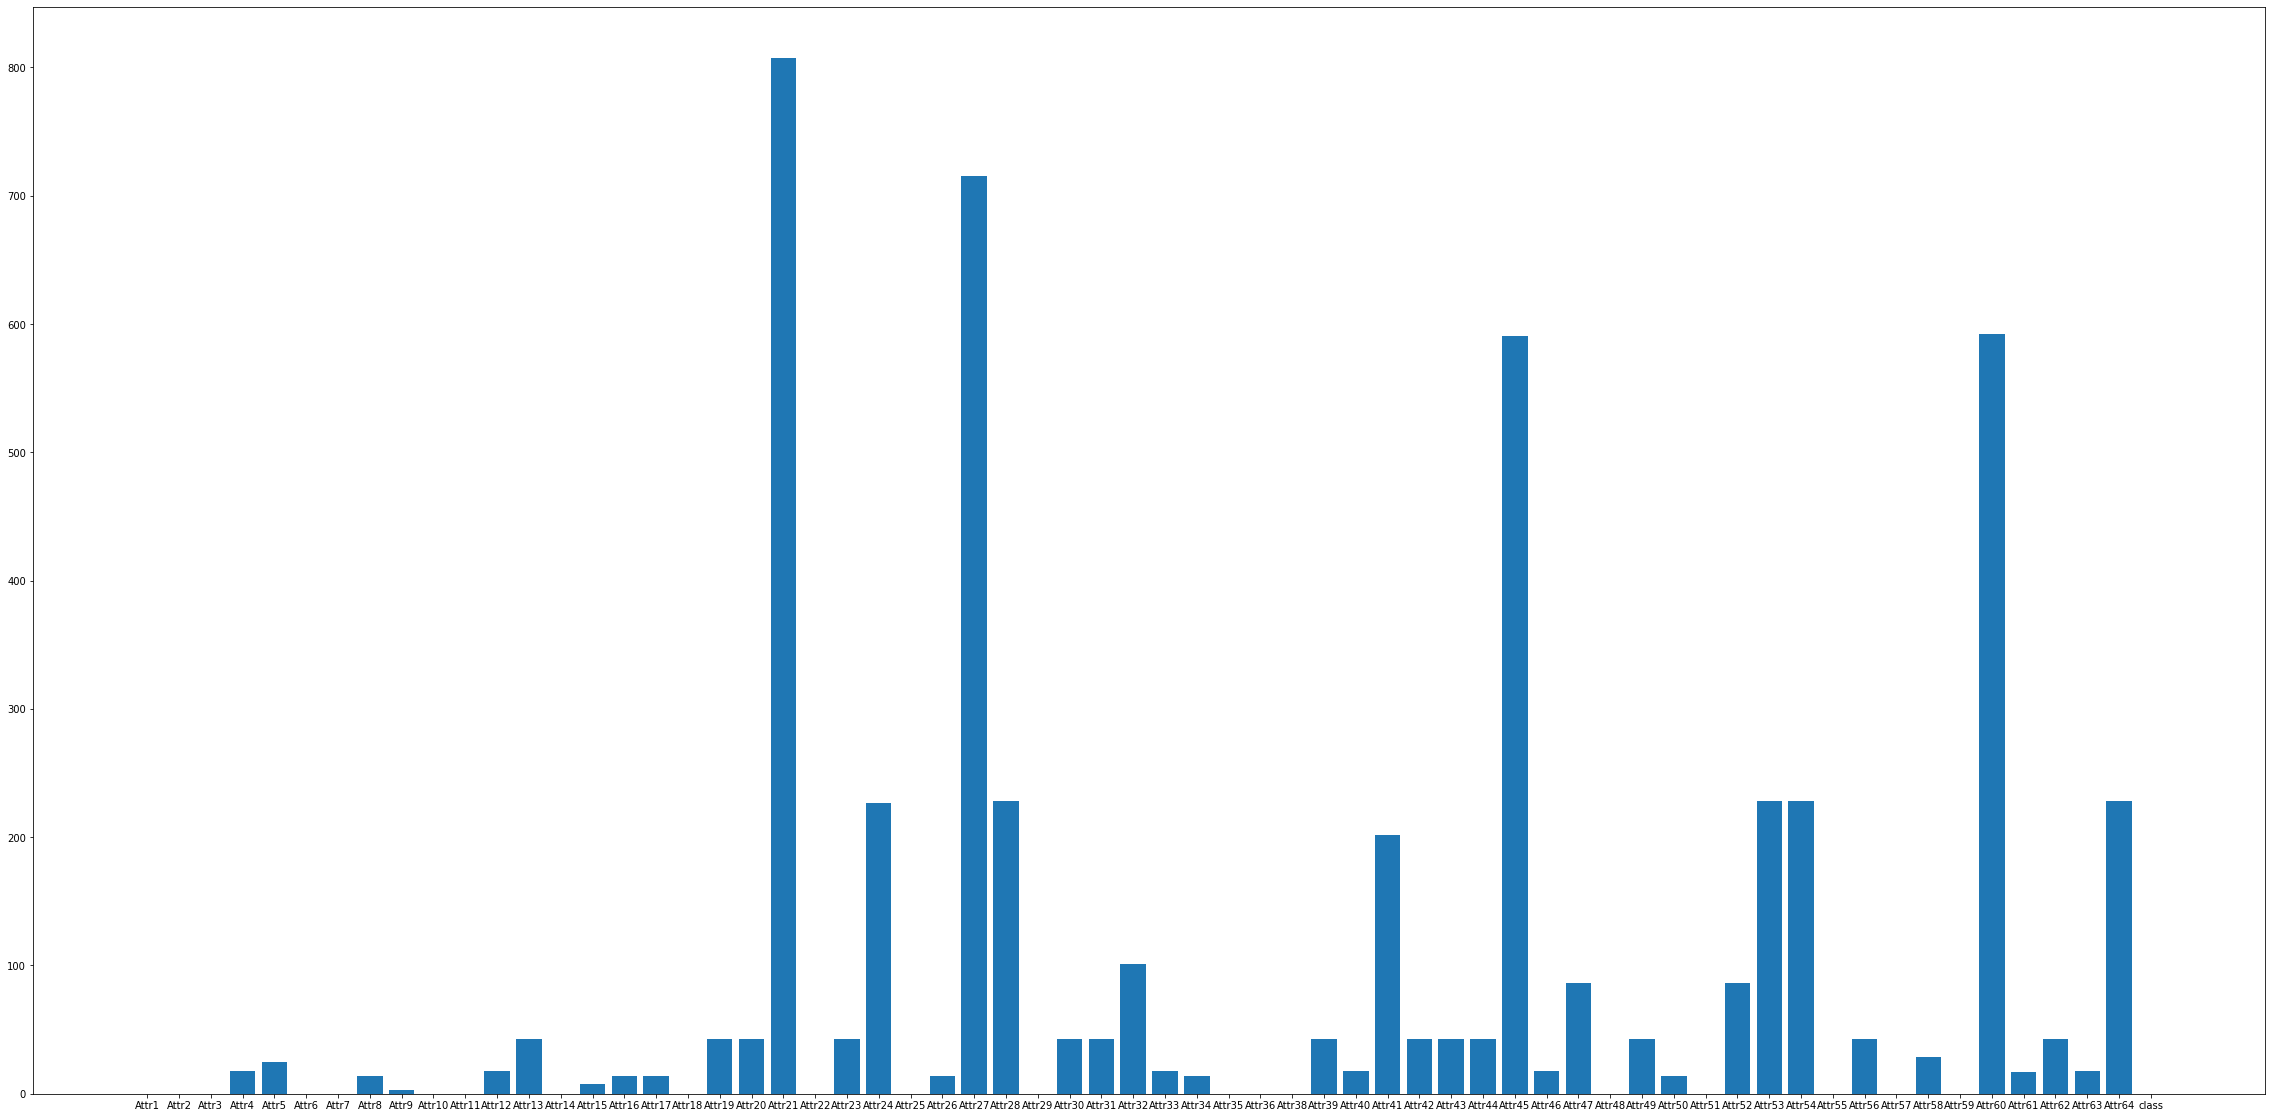

In [25]:
# Delete the column with highest number of nan values ie Column Attr37
df_binary_class = df_binary_class.drop(columns = ['Attr37'])
# Plot the null values graph after removing the Attr37 column
nan_columns = []
nan_values  = []

for column in df_binary_class.columns:
    nan_columns.append(column)
    nan_values.append(df_binary_class[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

<AxesSubplot:xlabel='class', ylabel='count'>

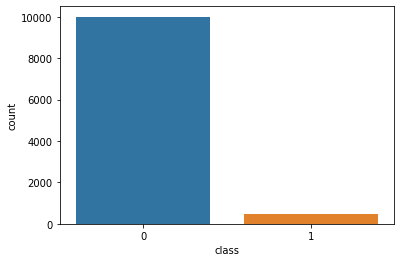

In [26]:
sns.countplot(x='class', data=df_binary_class)

Summary: Our data is highly imbalanced. The event rate of a company being bankrupt will be around 4.71% based on the data set provided.
In order to get a better accuracy rate instead of imputing the data as a whole we impute based on the 'class' attribute values. Create two different data frames according to the 'class' values and then concatenate the imputed data frames.

In [27]:
df_class_0 = df_binary_class[df_binary_class['class']==0]
df_class_1 = df_binary_class[df_binary_class['class']==1]

## 3. Data Imputation

### 3.a Imputation by median

In [28]:
#Data imputation via median on original data seperated by class = 0
df_median_imputed_0 = df_class_0.copy()
df_median_imputed_0 = Imputation(df_median_imputed_0, 'median')

In [29]:
#Data imputation via median on original data seperated by class = 1
df_median_imputed_1 = df_class_1.copy()
df_median_imputed_1 = Imputation(df_median_imputed_1, 'median')

<b>Firstly, we impute data by `median` in different class (0, 1) and will expand 3 methods with detection and treatment</b><br>

                                  `Median imputation`
                                       /        \
                                      /          \
                                     /            \
                                1.`IQR`          2.`Isolate Forest`
                        (detection, treatment)   (detection, treatment)
                                  /       
                                 /     
                                /
                          3.`Capping`  
                           (treatment) 
                                
                                
                                

## 4. Outlier detection & Treatment
Outliers are observations that are far away from the other data points in a random sample of a population. We often want to make assumptions about a specific population. Extreme values can have a significant impact on conclusions drawn from data.

<b>Commonly used methods for detection of outliers is:</b> 

1. `IQR detection`: Check data wether it is in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR). If not, other measures should be taken.

2. `Isolation Forest`: It explicitly isolates anomalies instead of profiling and constructing normal points and regions by assigning a score to each data point. It takes advantage of the fact that anomalies are the minority data points and that they have attribute-values that are very different from those of normal instances. 

<b>For the treatement of outliers there are several methods:</b>
1. `Quantile-based Flooring and Capping`:
    Here points below 10th percentile are replaced with 10th percentile values
    and  points above 90th percentile are replaced with 90th percentile values.
      
2. `IQR Score`:
    The rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed or impute values
    
3. `Replacing Outliers with Median Values`:
    We calculate the median and assign those values to the upper and lower datapoints




### 4.a Calculate skew of mdian imputation in class0 and class1

In [30]:
# Check the skewness of the data before the outlier treatment
print("Skewness of median imputed dataframe of class = 0")
df_median_imputed_0.skew(axis = 0)

Skewness of median imputed dataframe of class = 0


Attr1      58.804380
Attr2      97.672734
Attr3     -97.863285
Attr4      99.033423
Attr5     -94.660356
Attr6     -92.185119
Attr7      57.771479
Attr8      56.267600
Attr9      87.547103
Attr10    -97.514194
Attr11     56.327221
Attr12     64.347002
Attr13     93.327500
Attr14     57.771655
Attr15     78.508155
Attr16     64.648014
Attr17     55.556891
Attr18     52.874186
Attr19    -54.905561
Attr20     70.462111
Attr21     98.058069
Attr22     52.308575
Attr23    -55.655278
Attr24     62.084203
Attr25    -95.397486
Attr26     66.509008
Attr27     59.280458
Attr28     40.154786
Attr29     -0.018242
Attr30    -59.280437
Attr31    -55.803198
Attr32     89.749738
Attr33     35.129146
Attr34     73.593492
Attr35     52.526382
Attr36     33.571825
Attr38    -97.888340
Attr39    -51.448711
Attr40     55.326500
Attr41    100.029514
Attr42    -56.593337
Attr43     60.336240
Attr44     76.804605
Attr45     39.582294
Attr46     99.083419
Attr47     73.009292
Attr48     39.980174
Attr49    -59

In [31]:
# Check the skewness of the data before the outlier treatment
print("Skewness of median imputed dataframe of class = 1")
df_median_imputed_1.skew(axis = 0)

Skewness of median imputed dataframe of class = 1


Attr1     13.370165
Attr2     22.201301
Attr3    -22.213709
Attr4     16.720732
Attr5     -4.714490
Attr6    -22.199746
Attr7     13.278813
Attr8     20.436424
Attr9      7.677398
Attr10   -22.200855
Attr11    14.153122
Attr12   -22.132463
Attr13    20.698483
Attr14    13.278813
Attr15    12.782435
Attr16     6.847046
Attr17    20.429604
Attr18    13.278813
Attr19    20.893141
Attr20     3.767943
Attr21     9.688394
Attr22    -7.963196
Attr23    20.908668
Attr24   -18.992488
Attr25   -22.186081
Attr26     3.218165
Attr27    20.098243
Attr28    15.565592
Attr29    -0.293964
Attr30    21.431989
Attr31    21.234913
Attr32    22.073903
Attr33    21.744640
Attr34    12.628366
Attr35    -3.217926
Attr36    12.865438
Attr38   -22.203480
Attr39    -9.634896
Attr40    15.610402
Attr41    -5.176567
Attr42    12.857111
Attr43    20.155227
Attr44    20.895510
Attr45     3.229069
Attr46    15.575193
Attr47    21.220988
Attr48    -7.696695
Attr49     4.852058
Attr50    21.829727
Attr51    22.217778


### 4.b Check outliers by IQR method with tolerance of 1.5 IQR in class0 and class1

In [32]:
# check number of Outliers via IQR in columns with dataframe of class = 0
# Scale is 1.5 (Popular)
scale = 1.5
for column in df_median_imputed_0:
    outlier_detection_IQR(df_median_imputed_0[column], scale)

Attr1 	Total outliers is:  1148 	 	 Percentage Outliers:  11.471
Attr2 	Total outliers is:  267 	 	 Percentage Outliers:  2.668
Attr3 	Total outliers is:  239 	 	 Percentage Outliers:  2.388
Attr4 	Total outliers is:  1059 	 	 Percentage Outliers:  10.582
Attr5 	Total outliers is:  1508 	 	 Percentage Outliers:  15.068
Attr6 	Total outliers is:  2787 	 	 Percentage Outliers:  27.848
Attr7 	Total outliers is:  1023 	 	 Percentage Outliers:  10.222
Attr8 	Total outliers is:  1085 	 	 Percentage Outliers:  10.841
Attr9 	Total outliers is:  691 	 	 Percentage Outliers:  6.904
Attr10 	Total outliers is:  278 	 	 Percentage Outliers:  2.778
Attr11 	Total outliers is:  924 	 	 Percentage Outliers:  9.233
Attr12 	Total outliers is:  1416 	 	 Percentage Outliers:  14.149
Attr13 	Total outliers is:  1003 	 	 Percentage Outliers:  10.022
Attr14 	Total outliers is:  1023 	 	 Percentage Outliers:  10.222
Attr15 	Total outliers is:  1671 	 	 Percentage Outliers:  16.697
Attr16 	Total outliers is:  1

In [33]:
# check number of Outliers via IQR in columns with dataframe of class = 1
# Scale is 1.5 (Popular)
scale = 1.5
for column in df_median_imputed_1:
    outlier_detection_IQR(df_median_imputed_1[column], scale)

Attr1 	Total outliers is:  75 	 	 Percentage Outliers:  15.152
Attr2 	Total outliers is:  28 	 	 Percentage Outliers:  5.657
Attr3 	Total outliers is:  42 	 	 Percentage Outliers:  8.485
Attr4 	Total outliers is:  58 	 	 Percentage Outliers:  11.717
Attr5 	Total outliers is:  63 	 	 Percentage Outliers:  12.727
Attr6 	Total outliers is:  94 	 	 Percentage Outliers:  18.99
Attr7 	Total outliers is:  74 	 	 Percentage Outliers:  14.949
Attr8 	Total outliers is:  61 	 	 Percentage Outliers:  12.323
Attr9 	Total outliers is:  35 	 	 Percentage Outliers:  7.071
Attr10 	Total outliers is:  30 	 	 Percentage Outliers:  6.061
Attr11 	Total outliers is:  66 	 	 Percentage Outliers:  13.333
Attr12 	Total outliers is:  82 	 	 Percentage Outliers:  16.566
Attr13 	Total outliers is:  77 	 	 Percentage Outliers:  15.556
Attr14 	Total outliers is:  74 	 	 Percentage Outliers:  14.949
Attr15 	Total outliers is:  74 	 	 Percentage Outliers:  14.949
Attr16 	Total outliers is:  77 	 	 Percentage Outliers

<b>From `df_median_imputed_0` and `df_median_imputed_1`, we know that there are significantly skewed for each class. Some of attributes are over 15% of outliers.</b><br>


### 4.c Check anomalities by Isolated Forest in class0 and class1 

In [34]:
# Check outliers in median imputed data. 
# check number of Outliers in columns with dataframe of class = 0
df_anomalities_0 = df_median_imputed_0.copy()
df_anomalities_0 = outlier_detection_IF(df_anomalities_0)

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 The total number of anomalities in data is  1001


In [35]:
df_anomalities_0.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,anomaly
count,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.0,10008.000000
mean,0.056747,0.569086,0.144450,10.207129,-1.406993e+03,-0.069879,0.069754,19.867138,1.821278,0.417198,0.090693,2.684037,0.391075,0.069765,2.893466e+03,2.855246,21.253611,0.075122,-0.178823,68.700984,4.551157,0.080896,-0.184592,0.226419,0.251475,2.701403,1.153214e+03,6.059361,3.926993,0.329723,-0.186154,1.166420e+03,8.225202,5.445392,0.076758,1.969415,0.516020,-0.074788,2.354073,29.546344,-0.145515,196.630058,127.888096,17.307103,9.234239,5.614034e+02,0.008384,-0.222950,8.929521,0.448377,11.673721,5.715410,6.710377,6.893994e+03,-0.550661,0.023908,3.978946,1.436746,5.641191e+02,14.024573,9.478125e+01,9.103736,35.144879,0.0,0.799960
std,0.620799,4.839168,4.832888,535.919660,1.213330e+05,5.224381,0.624289,734.736127,7.753055,4.841621,0.630154,113.027997,50.782889,0.624288,1.106243e+05,112.847048,738.888534,0.822805,11.451258,1107.767690,301.091508,0.581559,11.388921,2.080906,5.090586,111.404745,3.429900e+04,95.614345,0.840649,72.677223,11.396908,6.963995e+04,26.536864,70.589021,0.581996,2.580355,4.836367,8.259051,37.900118,2886.639760,11.027440,3374.659343,2825.438033,1712.066679,535.838524,3.189642e+04,0.631971,12.175614,534.858710,4.830539,869.099162,90.714444,94.575170,6.113927e+04,57.228520,18.972780,194.578375,79.056957,3.697915e+04,85.607374,2.632723e+04,29.431665,431.827838,0.0,0.600083
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-274.570000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.0,-1.000000
25%,0.001688,0.248762,0.024004,1.060550,-4.922325e+01,0.000000,0.003665,0.454275,1.013500,0.307395,0.011792,0.009730,0.023151,0.003673,2.003575e+02,0.069621,1.475350,0.003673,0.002727,14.422750,0.811785,0.000000,0.001300,0.026311,0.146792,0.063632,1.975250e-02,0.049828,3.395700,0.071495,0.005242,4.441500e+01,2.831500,0.379385,0.003167,1.043500,0.441078,0.002671,0.056929,0.023979,0.000000,65.833000,34.562750,0.021387,0.624872,1.527050e+01,-0.046966,-0.033912,0.763075,0.174083,0.121608,0.702275,0.975982,3.325325e+01,0.007105,0.008476,0.874302,0.000000,5.783875e+00,4.492125,4.030200e+01,3.125700,2.057200,0.0,1.000000
50%,0.045404,0.455845,

In [36]:
# Check outliers in median imputed data. 
# check number of Outliers in columns with dataframe of class = 1
df_anomalities_1 = df_median_imputed_1.copy()
df_anomalities_1 = outlier_detection_IF(df_anomalities_1)

 The total number of anomalities in data is  50


C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [37]:
df_anomalities_1.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,anomaly
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0,495.000000
mean,-0.026058,1.647506,-0.894385,5.094358,-79.875680,-1.157958,-0.017876,3.930797,1.774441,-0.667160,0.007325,-3.185573,0.056182,-0.017876,5.210248e+03,0.119859,4.988661,-0.017876,0.009525,60.415567,1.030379,-0.029861,0.005508,-0.100797,-0.922376,0.074033,136.164051,4.173622,3.803631,3.059316,0.025083,1054.521652,12.219679,4.352590,-0.043826,2.220533,-0.555702,-0.098499,2.846533,0.058021,-0.048635,161.949431,101.465930,-0.154128,3.509976,72.263261,-0.066940,-0.095187,3.552102,1.482937,0.642139,3.848467,4.212683,1473.912191,-0.063525,-0.797765,1.047759,1.279176,45.775877,11.883244,954.000936,8.777557,33.739072,1.0,0.797980
std,1.052486,20.066524,20.051634,48.265703,426.110098,21.884731,1.054317,42.370659,2.001816,20.064870,1.039911,69.505258,2.080980,1.054317,7.348182e+04,3.747547,42.372682,1.054317,2.072597,78.456040,0.757616,0.575774,2.072276,1.836135,20.978810,3.368859,3620.243994,37.246079,0.830209,44.786528,2.061630,17350.420658,126.010039,15.652692,0.288624,3.491331,20.069109,0.495796,35.467194,3.774898,0.681062,576.065789,571.810745,17.383156,35.725268,375.697080,0.579440,0.808802,41.388301,20.068946,2.843206,26.025006,26.087997,22542.974717,0.795020,11.353636,0.738239,18.293456,291.841953,15.783340,16162.787015,58.339425,195.195159,0.0,0.603294
min,-9.743700,0.000000,-445.880000,0.002238,-4111.300000,-486.720000,-9.743700,-0.997710,0.000000,-445.860000,-8.935200,-1543.800000,-2.716400,-9.743700,-6.023600e+05,-46.667000,0.002238,-9.743700,-5.271000,0.000000,0.007234,-9.736700,-5.271000,-38.572000,-466.290000,-46.667000,-17235.000000,-40.787000,0.944980,-2.193000,-3.178100,0.133690,0.017077,-12.711000,-2.631700,0.000000,-445.860000,-7.755100,-0.043990,-58.523000,-3.487100,0.000000,0.000000,-206.410000,-0.043990,0.000000,-9.736700,-8.214000,0.002238,0.000000,0.000359,-39.776000,-39.776000,-146580.000000,-13.287000,-177.850000,0.000000,-94.598000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.000000
25%,-0.078606,0.454405,-0.123695,0.791990,-90.081000,-0.099009,-0.078816,0.156970,0.944805,0.135360,-0.064601,-0.188795,-0.038016,-0.078816,-1.428100e+03,-0.070625,1.165150,-0.078816,-0.071092,13.890500,0.845730,-0.064361,-0.072864,-0.100295,-0.041815,-0.068764,-0.289645,-0.265215,3.304500,0.174540,-0.057096,62.158500,2.136250,0.188130,-0.098192,1.047750,0.238440,-0.080087,0.025085,-0.102765,-0.056345,65.151000,29.333000,-0.447065,0.304380,12.939000,-0.105590,-0.102370,0.582285,0.302450,0.164900,0.351100,0.634215,-670.500000,-0.048296,-0.121870,0.923900,0.000000,4.636050,4.390350,61.077500,2.020500,2.013100,1.0,1.000000
50%,0.004423,0.665220,0.062291,1.135850,-31.588000,0.000000,0.006295,0.476980,1.124400,0.318410,0.018317,0.014280,0.018005,0.006295,1.085100e+03,0.045881,1.499800,0.006295,0.004180,40.652500,0.953130,0.018522,0.002087,0.012636,0.180200,0.037739,0.869430,0.116150,3.

### 4.d Outlier Treatment by IQR method

In [38]:
# Class = 1 outlier treatment using IQR method
df_treated_IQR_1 = df_median_imputed_1.copy()
for column in df_treated_IQR_1:
    outlier_treatment_IQR(df_treated_IQR_1[column], scale, df_treated_IQR_1) 

In [39]:
# Class = 0 outlier treatment using IQR method
df_treated_IQR_0 = df_median_imputed_0.copy()
for column in df_treated_IQR_0:
    outlier_treatment_IQR(df_treated_IQR_0[column], scale, df_treated_IQR_0) 

In [40]:
df_treated_IQR_1.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,-0.002747,0.628713,0.079753,1.123008,-34.961365,-0.016301,0.001559,0.488426,1.383043,0.357075,0.015858,-0.012604,0.020621,0.001559,1157.928552,0.036516,1.516350,0.001559,-0.001871,46.098430,0.944533,0.014317,-0.005091,0.005701,0.207631,0.033927,0.827175,0.183636,3.813647,0.346966,0.004450,112.760379,3.766792,1.968966,0.001340,1.784141,0.452041,-0.002437,0.109801,0.105992,0.009153,108.014966,54.632716,-0.033666,0.610456,43.923041,-0.018819,-0.014915,0.871629,0.503164,0.296329,0.841231,1.043960,239.179706,0.016906,0.050291,0.983072,0.075982,9.187142,7.569498,107.644289,3.710943,4.594936,1.0
std,0.084817,0.278790,0.265389,0.544963,62.301444,0.061146,0.092523,0.573734,0.799704,0.273425,0.101565,0.195412,0.060578,0.092523,3559.811112,0.160832,0.579790,0.092523,0.063832,39.855232,0.149300,0.098978,0.061254,0.151549,0.290257,0.140145,0.995863,0.726536,0.801165,0.278778,0.063656,70.627246,2.337513,2.020974,0.115958,1.026980,0.267852,0.081211,0.137782,0.262525,0.064114,60.200586,34.557435,0.436905,0.407735,37.758716,0.105066,0.079878,0.445382,0.277051,0.184658,0.715376,0.659697,1344.091049,0.088198,0.232441,0.086527,0.165103,6.848681,4.848930,65.898239,2.395414,3.898551,0.0
min,-0.261070,0.000000,-0.691170,0.002238,-234.890000,-0.247110,-0.273970,-0.997710,0.000000,-0.441890,-0.275890,-0.650990,-0.177480,-0.273970,-9254.600000,-0.431290,0.002238,-0.273970,-0.221360,0.000000,0.529510,-0.266750,-0.221360,-0.424380,-0.582870,-0.380130,-2.958700,-1.877100,1.740300,-0.485610,-0.202040,0.133690,0.017077,-1.942100,-0.343140,0.000000,-0.344980,-0.255820,-0.043990,-0.705060,-0.200860,0.000000,0.000000,-1.391800,-0.043990,0.000000,-0.324320,-0.279300,0.002238,0.000000,0.000359,-1.393700,-1.012600,-3943.300000,-0.229940,-0.640800,0.756650,-0.162590,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,-0.035551,0.454405,-0.085969,0.791990,-66.399000,-0.003859,-0.035958,0.156970,0.944805,0.189620,-0.025578,-0.087494,0.000846,-0.035958,-575.050000,-0.032836,1.165150,-0.035958,-0.015952,13.890500,0.894235,-0.028089,-0.017011,-0.051020,0.043071,-0.023204,0.869430,-0.167860,3.322500,0.183425,-0.009596,62.158500,2.136250,0.194700,-0.049444,1.047750,0.273885,-0.027659,0.025085,-0.013631,-0.007931,65.151000,29.333000,-0.093836,0.304380,12.939000,-0.060151,-0.033293,0.582285,0.302450,0.164900,0.463720,0.735545,-59.551500,-0.010592,-0.024407,0.946425,0.000000,4.636050,4.390350,61.077500,2.020500,2.013100,1.0
50%,0.004423,0.665220,0.062291,1.135850,-31.588000,0.000000,0.006295,0.476980,1.124400,0.318410,0.018317,0.014280,0.018005,0.006295,1085.100000,0.045881,1.499800,0.006295,0.004180,40.652500,0.953130,0.018522,0.002087,0.012636,0.180200,0.037739,0.869430,0.116150,3.873600,0.339455,0.007406,109.640000,3.508550,1.736750,0.007151,1.686400,0.439730,0.003810,0.070029,0.109480,0.010017,104.040000,52.153500,0.018077,0.594600,38.204500,

In [41]:
df_treated_IQR_0.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.0
mean,0.057590,0.463682,0.232689,1.835526,3.860345,0.011295,0.067706,1.430977,1.418498,0.520048,0.082835,0.214048,0.077359,0.067722,980.160485,0.296044,2.473142,0.067720,0.043017,37.950157,0.944664,0.071017,0.037007,0.193861,0.392939,0.268142,1.325649,0.579158,3.927433,0.224848,0.050239,81.848991,5.171447,2.533522,0.069908,1.667770,0.614216,0.045726,0.318195,0.091938,0.046209,100.765101,56.215600,0.340259,1.216141,41.195764,0.025680,0.015496,1.397189,0.348310,0.224203,1.290667,1.482984,1486.499091,0.062354,0.128492,0.942192,0.065549,11.096716,6.981282,74.641869,5.695057,4.710805,0.0
std,0.088468,0.267637,0.286449,1.161172,69.807082,0.048705,0.102209,1.436126,0.708415,0.266194,0.107798,0.375275,0.077968,0.102203,1243.715344,0.377911,1.460331,0.102203,0.060681,30.175845,0.202183,0.102597,0.052972,0.247237,0.302325,0.343344,2.283859,0.854183,0.777811,0.227459,0.066367,50.747842,3.301214,2.603604,0.102057,0.879449,0.227738,0.062756,0.391137,0.099530,0.063400,49.608998,30.411495,0.551031,0.862178,33.401699,0.106318,0.066067,0.938835,0.221420,0.139153,0.907449,0.826878,2644.861372,0.085694,0.174433,0.082514,0.130826,7.844523,3.661495,46.421115,3.595706,3.983330,0.0
min,-0.185670,0.000000,-0.577240,0.002080,-210.440000,-0.124390,-0.209370,-2.081800,-0.000084,-0.325330,-0.215370,-0.863780,-0.147280,-0.209370,-2705.500000,-0.817440,-0.043411,-0.209370,-0.127920,-0.001439,0.393670,-0.222300,-0.113410,-0.499460,-0.565360,-0.754360,-6.581000,-2.182200,1.816400,-0.441700,-0.138120,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.086709,-0.132930,-0.411990,-0.220310,-0.139440,-0.293730,0.000000,-1.314500,-0.079512,-17.303000,-0.272690,-0.175680,0.002080,0.000000,0.000000,-1.619200,-1.182200,-6681.000000,-0.180070,-0.384840,0.693380,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.0
25%,0.009253,0.248762,0.045122,1.060550,-29.672500,0.000000,0.011390,0.454275,1.013500,0.332653,0.021948,0.023040,0.031582,0.011406,331.297500,0.078188,1.475350,0.011406,0.009974,14.422750,0.828300,0.000685,0.008425,0.043537,0.184750,0.073111,0.245415,0.076802,3.412825,0.081372,0.014880,44.447000,2.831500,0.381532,0.010335,1.043500,0.469220,0.009052,0.057057,0.035851,0.004913,65.852500,34.585000,0.067831,0.624915,15.270500,-0.026938,-0.013747,0.763075,0.174083,0.121702,0.740573,1.003925,112.107500,0.015343,0.028918,0.903338,0.000000,5.783875,4.492300,40.316500,3.125700,2.057200,0.0
50%,0.045404,0.455843,0.205955,1.645900,3.284400,0.000000,0.054174,1.148700,1.200450,0.525320,0.071158,0.167200,0.069723,0.054229,800.905000,0.249590,2.191300,0.054229,0.034398,34.289000,0.955370,0.056921,0.028951,0.168500,0.391945,0.228830,1.071050,0.476710,3.935300,0.211230,0.041767,76.317500,4.737900,2.070900,0.055943,1.5

array([[<AxesSubplot:title={'center':'Attr1'}>,
        <AxesSubplot:title={'center':'Attr2'}>,
        <AxesSubplot:title={'center':'Attr3'}>,
        <AxesSubplot:title={'center':'Attr4'}>,
        <AxesSubplot:title={'center':'Attr5'}>,
        <AxesSubplot:title={'center':'Attr6'}>,
        <AxesSubplot:title={'center':'Attr7'}>,
        <AxesSubplot:title={'center':'Attr8'}>],
       [<AxesSubplot:title={'center':'Attr9'}>,
        <AxesSubplot:title={'center':'Attr10'}>,
        <AxesSubplot:title={'center':'Attr11'}>,
        <AxesSubplot:title={'center':'Attr12'}>,
        <AxesSubplot:title={'center':'Attr13'}>,
        <AxesSubplot:title={'center':'Attr14'}>,
        <AxesSubplot:title={'center':'Attr15'}>,
        <AxesSubplot:title={'center':'Attr16'}>],
       [<AxesSubplot:title={'center':'Attr17'}>,
        <AxesSubplot:title={'center':'Attr18'}>,
        <AxesSubplot:title={'center':'Attr19'}>,
        <AxesSubplot:title={'center':'Attr20'}>,
        <AxesSubplot:title=

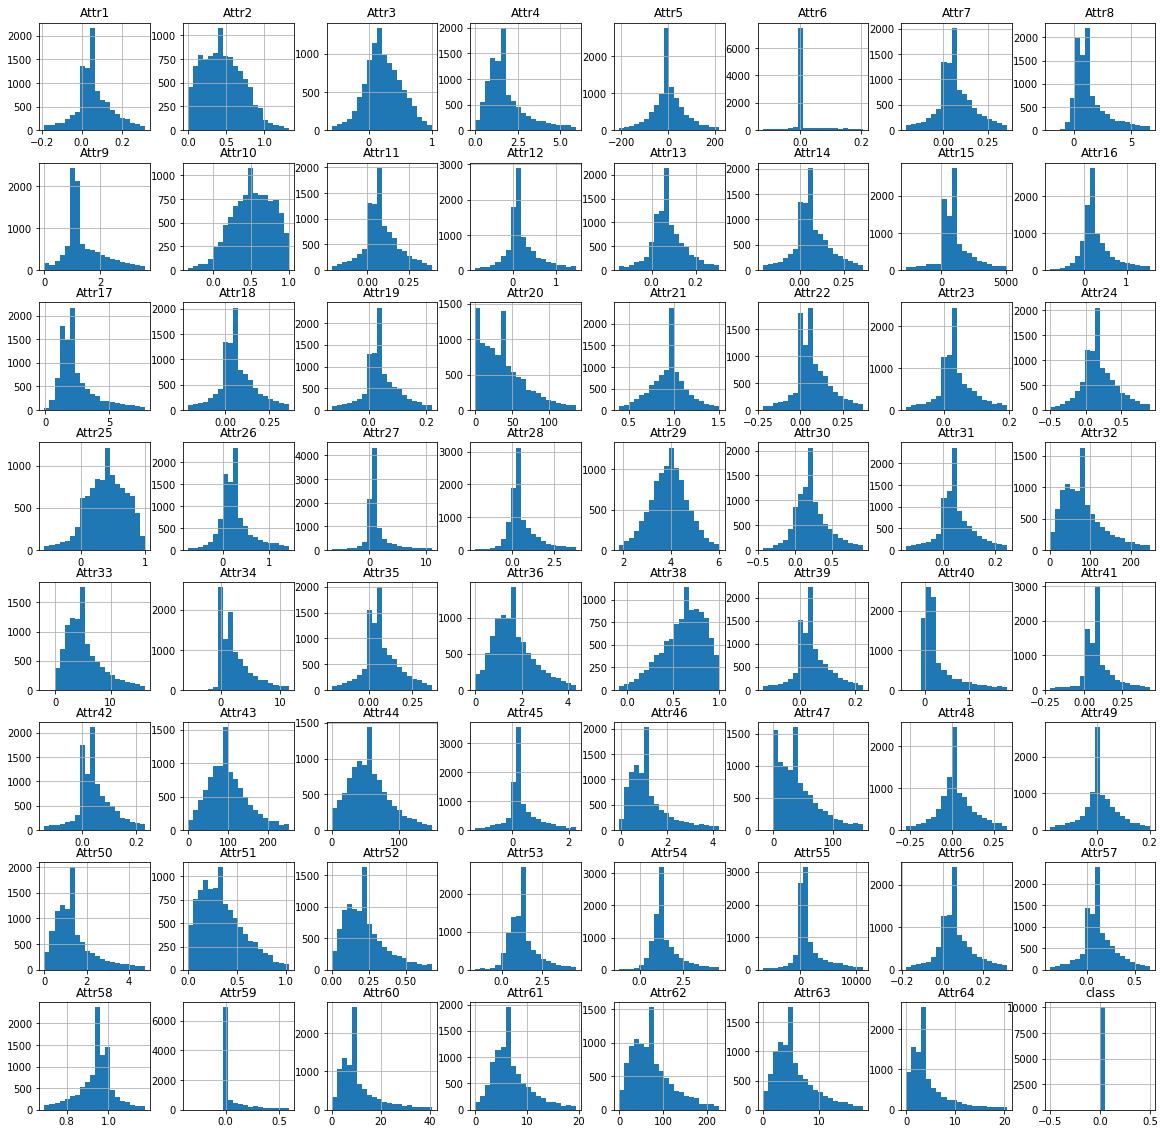

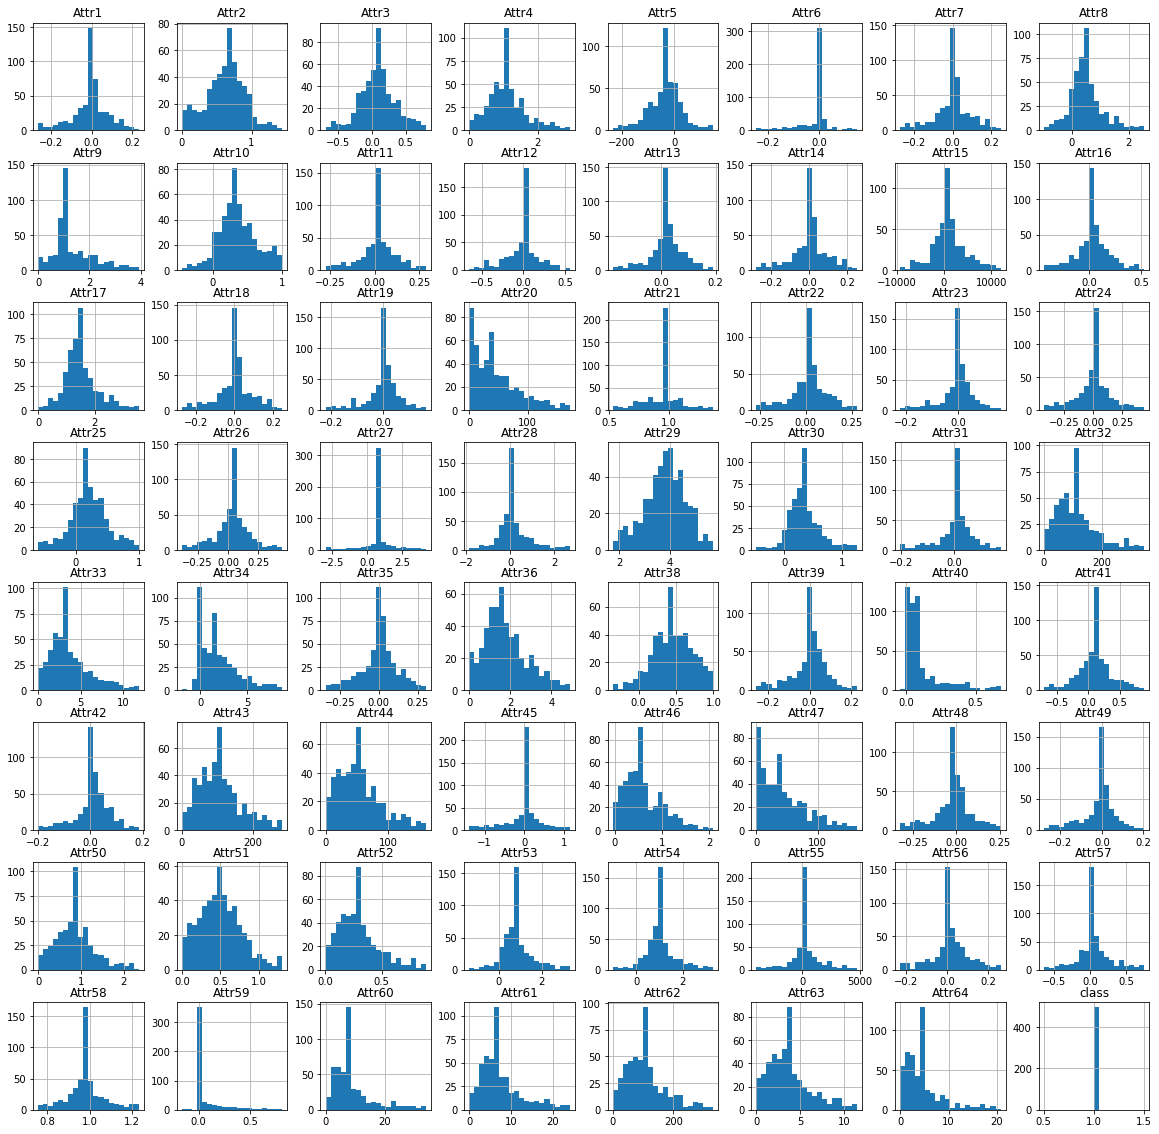

In [239]:
df_treated_IQR_0.hist(bins=20, figsize=(20, 20))
df_treated_IQR_1.hist(bins=20, figsize=(20, 20))

### 4.e Outlier Treatment by Isolation forest 

In [240]:
# Class = 0 outlier treatment using Isoaltion Forest
df_treated_anomaly_0 = outlier_treatment_IF(df_anomalities_0)

In [241]:
# Class = 1 outlier treatment using Isoaltion Forest
df_treated_anomaly_1 = outlier_treatment_IF(df_anomalities_1)

In [242]:
df_treated_anomaly_0.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,anomaly
count,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.0,9007.0
mean,0.060773,0.480229,0.212087,2.493541,-1.618562e+03,0.034841,0.073065,2.468781,1.664758,0.502778,0.090923,0.391397,0.083584,0.073065,3.042297e+03,0.516843,3.540570,0.073065,0.039884,47.640702,1.607693,0.082594,0.032497,0.241761,0.373798,0.467748,8.308544e+02,1.928138,3.998475,0.302143,0.048572,116.574996,6.387596,3.545992,0.079570,1.879939,0.595521,0.044340,0.710732,32.790974,0.046677,112.211213,64.552562,3.105363,1.741646,62.187689,0.021151,0.002795,1.994101,0.367515,0.337368,2.515093,2.763312,7.309576e+03,0.080076,0.125472,1.058021,0.580217,74.199087,12.042275,91.404641,7.018209,13.909827,0.0,1.0
std,0.130222,0.280773,0.279416,2.626345,1.276675e+05,0.817655,0.141102,4.308668,1.187025,0.279341,0.144488,0.874201,0.116207,0.141102,1.162759e+05,0.915676,4.381839,0.141102,0.099250,48.239434,37.885178,0.137984,0.093573,1.922665,0.349213,0.851214,3.129141e+04,6.246173,0.788646,0.616141,0.111323,886.432281,5.625228,4.916894,0.152480,1.265325,0.237589,0.103917,1.532485,3042.817018,0.092557,72.062021,51.575170,121.290652,2.124666,605.226328,0.196946,0.122103,2.326021,0.233867,2.564969,5.915157,5.997125,6.159493e+04,0.163188,3.189651,12.554019,19.964199,1392.645207,65.608201,85.271845,6.060199,60.339159,0.0,0.0
min,-0.771050,0.000000,-1.236800,0.022724,-1.190300e+07,-70.966000,-0.767070,-0.813730,0.000000,-4.368500,-0.738160,-6.236200,-0.800530,-0.767070,-2.321800e+06,-4.811100,0.186270,-0.767070,-0.885820,0.000000,0.000000,-0.770150,-0.885820,-1.399000,-4.435000,-4.811100,-1.901300e+05,-35.545000,-0.349690,-1.591800,-0.845040,-9295.600000,-0.039266,-3.419800,-1.916200,0.000000,-0.634650,-1.277600,-7.081900,-667.730000,-1.277600,0.000000,0.000000,-1010.400000,-6.469200,0.000000,-3.429600,-1.640600,0.010747,0.000000,-25.467000,-34.545000,-34.545000,-6.699300e+05,-0.896100,-238.360000,-0.425840,-142.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,0.004030,0.263120,0.033654,1.079950,-4.611300e+01,0.000000,0.006637,0.486725,1.020400,0.320355,0.016599,0.017016,0.026362,0.006637,3.005450e+02,0.081168,1.508400,0.006637,0.004307,15.962000,0.822920,0.000000,0.002777,0.037234,0.173810,0.074422,1.077150e-01,0.063727,3.473000,0.082153,0.007817,46.256500,2.964800,0.376355,0.006909,1.079200,0.450590,0.004763,0.055941,0.033901,0.000000,67.409000,35.602000,0.029714,0.639445,17.115000,-0.039277,-0.028115,0.784975,0.185650,0.126655,0.718310,0.989155,6.211650e+01,0.009830,0.010094,0.881290,0.000000,5.783650,4.574050,42.319000,3.252050,2.075150,0.0,1.0
50%,0.046216,0.457280,0.201730,1.618700,2.473600e+00,0.000000,0.055602,1.142000,1.198200,0.522540,0.072225,0.168160,0.069723,0.055602,9.189900e+02,0.249590,2.186800,0.055602,0.034420,35.142000,0.955370,0.060691,0.028970,0.168500,0.398980,0.228880,1.071050e+00,0.476710,3.990300,0.213220

In [243]:
df_treated_anomaly_1.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,anomaly
count,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,4.450000e+02,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.0,445.0
mean,-0.033765,0.696087,0.023918,1.580080,-65.818379,-0.118303,-0.026469,1.155454,1.692060,0.282606,-0.004576,-0.041274,-0.008213,-0.026469,5.901250e+03,0.062387,2.219422,-0.026469,-0.036186,58.241609,1.047015,-0.006806,-0.039677,0.018189,0.099067,0.044146,185.421084,1.792856,3.885001,0.517834,-0.026555,157.515303,5.027197,2.997250,-0.023704,2.030601,0.382730,-0.033952,0.353367,-0.017330,-0.023358,125.294809,67.053363,-1.057772,0.911374,56.492427,-0.043607,-0.051181,1.274704,0.560803,0.406314,2.117886,2.496135,1186.530102,0.012051,-0.457563,0.982376,1.096611,38.398208,11.391270,155.850064,4.943997,19.264033,1.0,1.0
std,0.159065,0.392918,0.401778,1.886602,175.000800,0.513119,0.167437,2.611726,1.307913,0.400475,0.167538,0.559845,0.126133,0.167437,7.740353e+04,0.488921,2.705410,0.167437,0.136248,67.794704,0.783238,0.169082,0.131692,0.335074,0.552748,0.466187,3727.118840,7.622868,0.774321,0.693560,0.131598,177.677584,5.778797,5.478231,0.198585,1.435792,0.379307,0.147555,1.051616,3.502212,0.136977,98.301727,68.454049,12.012517,1.378983,63.653876,0.182575,0.155089,1.777058,0.366912,0.463161,6.903412,7.269100,21629.769515,0.188313,9.281739,0.164052,18.591509,271.262588,13.678145,194.123236,5.844626,54.710949,0.0,0.0
min,-0.929470,0.000000,-2.147000,0.052336,-1436.000000,-7.664900,-0.929950,-0.758100,0.110050,-1.833000,-0.929950,-3.895900,-0.798700,-0.929950,-6.023600e+05,-3.035200,0.352990,-0.929950,-0.864090,0.000000,0.258440,-0.915460,-0.864090,-2.235800,-4.737300,-3.035200,-4636.000000,-13.677000,1.710600,-0.889060,-0.766550,6.595800,0.245920,-0.838740,-1.900800,0.000000,-1.833000,-0.867080,0.000000,-58.523000,-0.809970,0.000000,0.000000,-206.410000,0.001273,0.000000,-0.915460,-0.998710,0.052336,0.000000,0.018071,-12.676000,-12.676000,-146580.000000,-0.866300,-177.850000,0.000000,-94.598000,0.652710,0.434030,0.000000,0.194890,0.117520,1.0,1.0
25%,-0.069395,0.476910,-0.107710,0.803230,-89.644000,-0.083609,-0.071223,0.170680,0.969970,0.145290,-0.052887,-0.157640,-0.026713,-0.071223,-1.461500e+03,-0.058580,1.177300,-0.071223,-0.049113,15.403000,0.851400,-0.053863,-0.048972,-0.085132,-0.004737,-0.055613,-0.086516,-0.253200,3.422800,0.189600,-0.041065,67.589000,2.277700,0.192140,-0.077665,1.135700,0.243190,-0.059900,0.024486,-0.103440,-0.044194,66.539000,29.904000,-0.383740,0.311240,15.508000,-0.089748,-0.076549,0.592690,0.326920,0.173030,0.383760,0.640340,-784.670000,-0.036288,-0.119020,0.926920,0.000000,4.638200,4.491900,66.039000,2.104800,2.104200,1.0,1.0
50%,0.004445,0.668330,0.062029,1.131800,-34.502000,0.000000,0.006903,0.474190,1.136400,0.312380,0.018652,0.014708,0.018382,0.006903,1.407200e+03,0.047562,1.496300,0.006903,0.004291,41.551000,0.953130,0.020415,0.002446,0.014253,0.200230,0.039694,0.869430,0.116150,3.922800,0.339660,0.008144,110.320000,3.486200,1.724600,0.012019,1.720100,0.430340,

In [244]:
# Delete the column anomaly
df_treated_anomaly_1.drop(columns = ['anomaly'], inplace = True)
df_treated_anomaly_0.drop(columns = ['anomaly'], inplace = True)

In [245]:
df_treated_anomaly_0.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.000000,9007.0
mean,0.060773,0.480229,0.212087,2.493541,-1.618562e+03,0.034841,0.073065,2.468781,1.664758,0.502778,0.090923,0.391397,0.083584,0.073065,3.042297e+03,0.516843,3.540570,0.073065,0.039884,47.640702,1.607693,0.082594,0.032497,0.241761,0.373798,0.467748,8.308544e+02,1.928138,3.998475,0.302143,0.048572,116.574996,6.387596,3.545992,0.079570,1.879939,0.595521,0.044340,0.710732,32.790974,0.046677,112.211213,64.552562,3.105363,1.741646,62.187689,0.021151,0.002795,1.994101,0.367515,0.337368,2.515093,2.763312,7.309576e+03,0.080076,0.125472,1.058021,0.580217,74.199087,12.042275,91.404641,7.018209,13.909827,0.0
std,0.130222,0.280773,0.279416,2.626345,1.276675e+05,0.817655,0.141102,4.308668,1.187025,0.279341,0.144488,0.874201,0.116207,0.141102,1.162759e+05,0.915676,4.381839,0.141102,0.099250,48.239434,37.885178,0.137984,0.093573,1.922665,0.349213,0.851214,3.129141e+04,6.246173,0.788646,0.616141,0.111323,886.432281,5.625228,4.916894,0.152480,1.265325,0.237589,0.103917,1.532485,3042.817018,0.092557,72.062021,51.575170,121.290652,2.124666,605.226328,0.196946,0.122103,2.326021,0.233867,2.564969,5.915157,5.997125,6.159493e+04,0.163188,3.189651,12.554019,19.964199,1392.645207,65.608201,85.271845,6.060199,60.339159,0.0
min,-0.771050,0.000000,-1.236800,0.022724,-1.190300e+07,-70.966000,-0.767070,-0.813730,0.000000,-4.368500,-0.738160,-6.236200,-0.800530,-0.767070,-2.321800e+06,-4.811100,0.186270,-0.767070,-0.885820,0.000000,0.000000,-0.770150,-0.885820,-1.399000,-4.435000,-4.811100,-1.901300e+05,-35.545000,-0.349690,-1.591800,-0.845040,-9295.600000,-0.039266,-3.419800,-1.916200,0.000000,-0.634650,-1.277600,-7.081900,-667.730000,-1.277600,0.000000,0.000000,-1010.400000,-6.469200,0.000000,-3.429600,-1.640600,0.010747,0.000000,-25.467000,-34.545000,-34.545000,-6.699300e+05,-0.896100,-238.360000,-0.425840,-142.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.004030,0.263120,0.033654,1.079950,-4.611300e+01,0.000000,0.006637,0.486725,1.020400,0.320355,0.016599,0.017016,0.026362,0.006637,3.005450e+02,0.081168,1.508400,0.006637,0.004307,15.962000,0.822920,0.000000,0.002777,0.037234,0.173810,0.074422,1.077150e-01,0.063727,3.473000,0.082153,0.007817,46.256500,2.964800,0.376355,0.006909,1.079200,0.450590,0.004763,0.055941,0.033901,0.000000,67.409000,35.602000,0.029714,0.639445,17.115000,-0.039277,-0.028115,0.784975,0.185650,0.126655,0.718310,0.989155,6.211650e+01,0.009830,0.010094,0.881290,0.000000,5.783650,4.574050,42.319000,3.252050,2.075150,0.0
50%,0.046216,0.457280,0.201730,1.618700,2.473600e+00,0.000000,0.055602,1.142000,1.198200,0.522540,0.072225,0.168160,0.069723,0.055602,9.189900e+02,0.249590,2.186800,0.055602,0.034420,35.142000,0.955370,0.060691,0.028970,0.168500,0.398980,0.228880,1.071050e+00,0.476710,3.990300,0.213220,0.041767,76.317500,4.740800,2.

### 4.f Outlier Treatment by Capping

In [246]:
# class = 0 outlier treatment using capping 
df_treated_capping_0 =df_median_imputed_0.copy()
for column in df_treated_capping_0:
    outlier_treatment_Capping(df_treated_capping_0[column], scale, df_treated_capping_0)

In [247]:
# class = 1 outlier treatment using capping 
df_treated_capping_1 =df_median_imputed_1.copy()
for column in df_treated_capping_1:
    outlier_treatment_Capping(df_treated_capping_1[column], scale, df_treated_capping_1)

In [248]:
df_treated_capping_0.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10008.000000,10008.000000,10008.000000,10008.000000,10008.00000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.0
mean,0.058710,0.486770,0.214414,2.290872,5.39768,0.029063,0.069833,2.027122,1.585306,0.497349,0.086866,0.319848,0.080794,0.069844,1164.739559,0.424654,3.083678,0.069882,0.041920,44.268626,0.961147,0.076683,0.035121,0.206643,0.359692,0.383259,2.496187,0.953974,3.927472,0.263627,0.049756,94.753015,6.084714,3.266525,0.074247,1.814879,0.593130,0.044903,0.515613,0.110862,0.046111,109.430795,61.529356,0.481278,1.559156,48.692383,0.024776,0.008590,1.773157,0.370056,0.259945,1.636289,1.842342,2453.219517,0.070475,0.139298,0.933738,0.137198,14.906702,8.198669,86.315052,6.752486,6.858473,0.0
std,0.122494,0.301193,0.312169,1.711110,108.92902,0.101573,0.136691,2.156124,0.897804,0.300569,0.141985,0.581767,0.106219,0.136683,2018.396583,0.570188,2.196798,0.136790,0.086994,38.298976,0.249584,0.134138,0.077498,0.314961,0.351414,0.522259,4.726963,1.418127,0.823357,0.305601,0.094925,67.077742,4.442200,3.547033,0.136086,1.065547,0.257655,0.087348,0.626718,0.166834,0.086172,60.798293,37.249444,0.935282,1.279628,42.965662,0.145637,0.094629,1.396078,0.250257,0.184464,1.475899,1.380550,4547.153364,0.122138,0.259114,0.117737,0.229865,12.545279,5.183078,61.265663,4.918094,6.621874,0.0
min,-0.186277,0.000000,-0.579500,0.002080,-210.78450,-0.124440,-0.209467,-2.081800,-0.551863,-0.328436,-0.216309,-0.865834,-0.147795,-0.209447,-2709.593750,-0.830647,-0.043411,-0.209713,-0.128087,-0.001439,0.393562,-0.223061,-0.113415,-0.501190,-0.566660,-0.756730,-6.585156,-2.188093,1.808738,-0.443435,-0.138279,-77.861250,-1.921900,-6.294550,-0.214446,-0.000084,-0.086784,-0.133082,-1.013217,-0.220717,-0.139502,-46.392500,-34.540750,-1.317451,-1.571469,-17.303000,-0.272769,-0.175924,0.002080,0.000000,-0.214670,-1.627375,-1.188919,-6687.266875,-0.180121,-0.387250,0.693357,-0.353524,0.000000,-4.539188,-72.450000,-0.000156,-0.000102,0.0
25%,0.001688,0.248762,0.024004,1.060550,-49.22325,0.000000,0.003665,0.454275,1.013500,0.307395,0.011792,0.009730,0.023151,0.003673,200.357500,0.069621,1.475350,0.003673,0.002727,14.422750,0.811785,0.000000,0.001300,0.026311,0.146792,0.063632,0.019752,0.049828,3.395700,0.071495,0.005242,44.415000,2.831500,0.379385,0.003167,1.043500,0.441078,0.002671,0.056929,0.023979,0.000000,65.833000,34.562750,0.021387,0.624872,15.270500,-0.046966,-0.033912,0.763075,0.174083,0.121608,0.702275,0.975982,33.253250,0.007105,0.008476,0.874302,0.000000,5.783875,4.492125,40.302000,3.125700,2.057200,0.0
50%,0.045404,0.455845,0.205955,1.645900,3.28440,0.000000,0.054174,1.148700,1.200450,0.525320,0.071158,0.167200,0.069723,0.054229,800.905000,0.249590,2.191300,0.054229,0.034398,34.289000,0.955370,0.056921,0.028951,0.168500,0.391945,0.228830,1.071050,0.476710,3.935300,0.211230,0.041767,76.317500,4.737900,2.070900,0.055943,

In [249]:
df_treated_capping_1.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,-0.023492,0.673900,0.055548,1.342431,-43.696309,-0.047304,-0.018368,0.746405,1.582173,0.310994,0.001641,-0.028136,-0.000282,-0.018368,1318.555017,0.046070,1.787273,-0.018368,-0.026512,53.442798,0.954694,-0.002007,-0.030100,0.004275,0.132844,0.034266,0.648639,0.397258,3.804789,0.439282,-0.016364,136.614658,4.586024,2.490027,-0.019774,1.932931,0.410114,-0.028281,0.200427,0.108948,-0.014515,119.718782,62.078166,-0.103480,0.775328,50.990878,-0.037015,-0.044592,1.030456,0.538541,0.352897,1.014845,1.239208,318.814615,0.009672,0.053142,0.987803,0.182977,12.391721,9.408071,133.322178,4.446049,7.211852,1.0
std,0.129062,0.339345,0.345531,0.816165,93.939415,0.108782,0.138317,0.893153,1.028842,0.333634,0.145519,0.318839,0.096516,0.138317,5501.815330,0.250404,0.922196,0.138317,0.103128,49.448275,0.212162,0.141124,0.098877,0.220654,0.385297,0.227320,2.221211,1.226410,0.823069,0.411816,0.099044,100.741377,3.361939,2.737846,0.158812,1.216874,0.323347,0.115944,0.248448,0.421043,0.101942,74.734856,43.707838,0.707487,0.626940,47.035615,0.151839,0.121986,0.644478,0.323820,0.256623,1.235500,1.159818,2542.246132,0.129951,0.386106,0.129486,0.336277,10.634288,7.038052,98.938108,3.309219,7.055445,0.0
min,-0.265142,0.000000,-0.692338,0.002238,-237.482175,-0.247522,-0.276917,-0.997710,0.000000,-0.441923,-0.277992,-0.652422,-0.180534,-0.276917,-9555.250000,-0.434352,0.002238,-0.276917,-0.222312,0.000000,0.526950,-0.270436,-0.221955,-0.426987,-0.660439,-0.394276,-3.001637,-2.044087,1.723350,-0.488602,-0.202182,0.133690,0.017077,-5.033400,-0.346849,0.000000,-0.358507,-0.264566,-0.043990,-0.705285,-0.208697,0.000000,0.000000,-1.424135,-0.043990,0.000000,-0.326306,-0.292734,0.002238,0.000000,0.000359,-1.455650,-1.021313,-3966.900000,-0.235931,-0.654993,0.738500,-0.485895,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,-0.078606,0.454405,-0.123695,0.791990,-90.081000,-0.099009,-0.078816,0.156970,0.944805,0.135360,-0.064601,-0.188795,-0.038016,-0.078816,-1428.100000,-0.070625,1.165150,-0.078816,-0.071092,13.890500,0.845730,-0.064361,-0.072864,-0.100295,-0.041815,-0.068764,-0.289645,-0.265215,3.304500,0.174540,-0.057096,62.158500,2.136250,0.188130,-0.098192,1.047750,0.238440,-0.080087,0.025085,-0.102765,-0.056345,65.151000,29.333000,-0.447065,0.304380,12.939000,-0.105590,-0.102370,0.582285,0.302450,0.164900,0.351100,0.634215,-670.500000,-0.048296,-0.121870,0.923900,0.000000,4.636050,4.390350,61.077500,2.020500,2.013100,1.0
50%,0.004423,0.665220,0.062291,1.135850,-31.588000,0.000000,0.006295,0.476980,1.124400,0.318410,0.018317,0.014280,0.018005,0.006295,1085.100000,0.045881,1.499800,0.006295,0.004180,40.652500,0.953130,0.018522,0.002087,0.012636,0.180200,0.037739,0.869430,0.116150,3.873600,0.339455,0.007406,109.640000,3.508550,1.736750,0.007151,1.686400,0.439730,0.003810,0.070029,0.109480,0.010017,104.040000,52.153500,0.018077,0.5

<b>Skewness is significantly reduced and some of attributes are looked like normal distribution in 3 methods of treatment. In addition, we have made data lower stdandard deviation. (It is possible to narrow down difference between maxium and minimum)</b><br>

<b>Trying to process data set to more centralised</b>

### 4.g Concatinating the dataframes

<b> Concatination of df_median_imputed_0 and df_median_imputed_1 </b>

In [250]:
df_median_imputed = pd.concat([df_median_imputed_0, df_median_imputed_1])
df_median_imputed.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.966167,-1.344447e+03,-0.121159,0.065624,19.116068,1.819070,0.366093,0.086764,2.407406,0.375292,0.065634,3.002654e+03,2.726329,20.487054,0.070739,-0.169947,68.310497,4.385225,0.075676,-0.175632,0.210998,0.196153,2.577577,1.105281e+03,5.970487,3.921179,0.458367,-0.176198,1.161146e+03,8.413460,5.393889,0.071075,1.981250,0.465510,-0.075906,2.377282,28.156578,-0.140949,194.995581,126.642835,16.484166,8.964458,5.383505e+02,0.004834,-0.216928,8.676086,0.497135,11.153809,5.627422,6.592662,6.638549e+03,-0.527703,-0.014817,3.840801,1.429319,5.396899e+02,13.923654,1.352757e+02,9.088363,35.078624,0.047129
std,0.647797,6.427041,6.420056,523.243080,1.184394e+05,6.970625,0.651152,717.278474,7.580584,6.428603,0.655407,111.364122,49.573752,0.651151,1.091565e+05,110.160013,721.331800,0.835328,11.187235,1081.481194,293.911052,0.581734,11.126433,2.071102,6.742161,108.751468,3.349082e+04,93.683591,0.840528,71.607994,11.134148,6.808302e+04,37.664766,68.989341,0.572124,2.630705,6.425362,8.062780,37.787522,2817.796456,10.765453,3296.545706,2760.839921,1671.239869,523.116826,3.113592e+04,0.629770,11.886534,522.179994,6.420885,848.373390,88.731371,92.494159,5.989196e+04,55.863902,18.684047,189.938495,77.273270,3.609736e+04,83.636834,2.593790e+04,31.392591,423.648786,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040900,-5.196150e+01,0.000000,0.002118,0.431935,1.011350,0.297340,0.009809,0.006372,0.020868,0.002131,1.867450e+02,0.060454,1.450350,0.002131,0.001742,14.400500,0.813550,0.000000,0.000639,0.017663,0.135695,0.055273,1.449050e-02,0.035968,3.393200,0.074598,0.004132,4.511250e+01,2.789700,0.370620,0.001730,1.043500,0.426810,0.001677,0.053836,0.022861,0.000000,65.740000,34.298000,0.014509,0.603425,1.514850e+01,-0.048988,-0.035852,0.749810,0.177200,0.123250,0.680975,0.958225,1.462100e+01,0.005336,0.006796,0.875700,0.000000,5.734300e+00,4.490600,4.092850e+01,3.064050,2.055600,0.000000
50%,0.043034,0.464140,0.198560,1.607500,1.713300e+00,0

<b> Concatination of df_treated_IQR_0 and df_treated_IQR_1 </b>

In [251]:
df_treated_IQR = pd.concat([df_treated_IQR_0, df_treated_IQR_1])
df_treated_IQR.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000
mean,0.054746,0.471460,0.225481,1.801945,2.030702,0.009994,0.064588,1.386555,1.416827,0.512367,0.079678,0.203366,0.074685,0.064604,988.538586,0.283812,2.428049,0.064602,0.040901,38.334180,0.944658,0.068345,0.035023,0.184993,0.384206,0.257103,1.302156,0.560518,3.922071,0.230603,0.048081,83.305826,5.105247,2.506914,0.066677,1.673254,0.606573,0.043456,0.308373,0.092600,0.044463,101.106782,56.141000,0.322636,1.187595,41.324299,0.023583,0.014063,1.372420,0.355609,0.227602,1.269485,1.462293,1427.713688,0.060212,0.124806,0.944119,0.066041,11.006719,7.009005,76.197253,5.601547,4.705344,0.047129
std,0.089216,0.270431,0.287314,1.149583,69.954355,0.049703,0.102730,1.421489,0.712978,0.268754,0.108441,0.371883,0.078165,0.102725,1439.244612,0.374602,1.445330,0.102725,0.061570,30.746746,0.200000,0.103127,0.054128,0.246810,0.304299,0.340171,2.242314,0.852698,0.779262,0.231570,0.066945,52.263856,3.275665,2.581798,0.103771,0.887241,0.232327,0.064553,0.385513,0.112650,0.063915,50.178557,30.619498,0.551890,0.855927,33.622693,0.106672,0.067088,0.928226,0.226724,0.142438,0.904321,0.825002,2611.595429,0.086349,0.178350,0.083155,0.132649,7.810645,3.727756,48.026411,3.573012,3.979269,0.211926
min,-0.261070,0.000000,-0.691170,0.002080,-234.890000,-0.247110,-0.273970,-2.081800,-0.000084,-0.441890,-0.275890,-0.863780,-0.177480,-0.273970,-9254.600000,-0.817440,-0.043411,-0.273970,-0.221360,-0.001439,0.393670,-0.266750,-0.221360,-0.499460,-0.582870,-0.754360,-6.581000,-2.182200,1.740300,-0.485610,-0.202040,-0.002254,-1.921900,-5.502500,-0.343140,-0.000084,-0.344980,-0.255820,-0.411990,-0.705060,-0.200860,-0.293730,0.000000,-1.391800,-0.079512,-17.303000,-0.324320,-0.279300,0.002080,0.000000,0.000000,-1.619200,-1.182200,-6681.000000,-0.229940,-0.640800,0.693380,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.006776,0.253955,0.037879,1.040900,-31.855500,0.000000,0.008790,0.431935,1.011450,0.320355,0.018480,0.016271,0.028521,0.008808,320.550000,0.066964,1.450350,0.008808,0.008049,14.400500,0.830755,0.000000,0.006664,0.032363,0.176300,0.062188,0.274690,0.065968,3.410200,0.084048,0.012512,45.139500,2.789700,0.375165,0.007777,1.043500,0.455380,0.007482,0.053887,0.035143,0.004197,65.809500,34.307000,0.048534,0.594780,15.148500,-0.028264,-0.014658,0.749810,0.177200,0.123415,0.727230,0.993755,101.600000,0.014174,0.026718,0.905325,0.000000,5.734300,4.491000,40.938500,3.064050,2.055600,0.000000
50%,0.045404,0.455845,0.205955,1.591400,3.284400,0.000000,0.054174,1.094300,1.194300,0.525320,0.071158,0.167200,0.069723,0.054229,800.905000,0.244870,2.134700,0.054229,0.034398,34.289000,0.955370,0.056921,0.028951,0.168500,0.391945,0.225830,1.071050,0.476710,3.935300,0.211230,0.041767,76.317500,4.640

<b> Concatination of df_treated_anomaly_0 and df_treated_anomaly_1 </b>

In [252]:
df_treated_anomaly = pd.concat([df_treated_anomaly_0, df_treated_anomaly_1])
df_treated_anomaly.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,9452.000000,9452.000000,9452.000000,9452.000000,9.452000e+03,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9.452000e+03,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9.452000e+03,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9.452000e+03,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000
mean,0.056322,0.490392,0.203228,2.450535,-1.545459e+03,0.027631,0.068379,2.406950,1.666044,0.492412,0.086427,0.371027,0.079262,0.068379,3.176897e+03,0.495448,3.478371,0.068379,0.036302,48.139793,1.581296,0.078385,0.029099,0.231235,0.360864,0.447805,8.004674e+02,1.921769,3.993132,0.312298,0.045035,118.502465,6.323549,3.520157,0.074708,1.887033,0.585502,0.040654,0.693907,31.246359,0.043380,112.827188,64.670300,2.909362,1.702557,61.919556,0.018102,0.000254,1.960232,0.376615,0.340614,2.496393,2.750733,7.021303e+03,0.076873,0.098023,1.054460,0.604529,72.513583,12.011625,94.438731,6.920555,14.161903,0.047080
std,0.133225,0.290629,0.289084,2.603375,1.246260e+05,0.806537,0.143992,4.253039,1.192930,0.289943,0.147043,0.866814,0.118295,0.143992,1.147402e+05,0.905252,4.326502,0.143992,0.102560,49.380547,36.983093,0.140871,0.096913,1.878857,0.365989,0.841849,3.055684e+04,6.317307,0.788303,0.621643,0.113473,866.211815,5.639605,4.945799,0.156482,1.274178,0.250163,0.107648,1.515129,2970.326085,0.096254,73.553223,52.489762,118.432649,2.102836,590.968309,0.196763,0.124370,2.308074,0.245192,2.505909,5.965534,6.062808,6.032379e+04,0.165075,3.709093,12.254965,19.901072,1360.755536,64.113729,94.263572,6.065855,60.094050,0.211821
min,-0.929470,0.000000,-2.147000,0.022724,-1.190300e+07,-70.966000,-0.929950,-0.813730,0.000000,-4.368500,-0.929950,-6.236200,-0.800530,-0.929950,-2.321800e+06,-4.811100,0.186270,-0.929950,-0.885820,0.000000,0.000000,-0.915460,-0.885820,-2.235800,-4.737300,-4.811100,-1.901300e+05,-35.545000,-0.349690,-1.591800,-0.845040,-9295.600000,-0.039266,-3.419800,-1.916200,0.000000,-1.833000,-1.277600,-7.081900,-667.730000,-1.277600,0.000000,0.000000,-1010.400000,-6.469200,0.000000,-3.429600,-1.640600,0.010747,0.000000,-25.467000,-34.545000,-34.545000,-6.699300e+05,-0.896100,-238.360000,-0.425840,-142.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002972,0.268292,0.025416,1.061325,-4.873650e+01,0.000000,0.004976,0.463023,1.018000,0.310468,0.014195,0.012939,0.023637,0.004976,2.880550e+02,0.072393,1.486250,0.004976,0.003223,15.909750,0.823887,0.000000,0.001828,0.028693,0.162950,0.066081,1.027950e-01,0.048024,3.471200,0.085421,0.006249,46.873250,2.916200,0.366395,0.005249,1.080575,0.439613,0.003595,0.053212,0.033023,0.000000,67.365750,35.408000,0.020195,0.616620,16.987750,-0.041236,-0.029114,0.773010,0.189380,0.128222,0.702275,0.968245,4.483850e+01,0.008506,0.007876,0.883045,0.000000,5.737500,4.570525,42.994500,3.183200,2.075950,0.000000
50%,0.043983,0.466035,0.193595,1.577450,6.785700e-01,0.000000,0.052184,1.103900,1.197050,0.512610,0.069288,0.157485,0.066456,0.052184,9.250900e+02,0.236070,2.145400,0.052184,0.032515,35.269500,0.955370,0.057608,0.027409,0.168500,0.387260,0.213780,1.071050e+00,0.465560,3.986050,0.219305,0.039

<b> Concatination of df_treated_capping_0 and df_treated_capping_1 </b>

In [253]:
df_treated_capping = pd.concat([df_treated_capping_0, df_treated_capping_1])
df_treated_capping.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000
mean,0.054836,0.495590,0.206927,2.246172,3.083910,0.025464,0.065676,1.966763,1.585158,0.488566,0.082849,0.303448,0.076973,0.065687,1171.988787,0.406811,3.022580,0.065723,0.038695,44.700999,0.960843,0.072974,0.032047,0.197105,0.349001,0.366811,2.409113,0.927737,3.921690,0.271905,0.046640,96.725928,6.014081,3.229929,0.069816,1.820443,0.584505,0.041453,0.500759,0.110771,0.043253,109.915661,61.555221,0.453718,1.522215,48.800709,0.021863,0.006083,1.738154,0.377997,0.264325,1.607001,1.813917,2352.626313,0.067609,0.135237,0.936286,0.139355,14.788173,8.255668,88.530469,6.643785,6.875128,0.047129
std,0.124035,0.305665,0.315604,1.691635,108.764010,0.103196,0.138032,2.130949,0.904351,0.304761,0.143289,0.576819,0.107164,0.138026,2303.655004,0.564958,2.171162,0.138128,0.089005,38.941891,0.247942,0.135499,0.079836,0.314093,0.356322,0.517493,4.655792,1.414554,0.823715,0.313613,0.096145,69.594826,4.408581,3.516832,0.138672,1.073385,0.263969,0.090239,0.617760,0.186710,0.087917,61.560409,37.576546,0.934036,1.267419,43.166421,0.146514,0.096745,1.378942,0.256679,0.189497,1.471311,1.376843,4495.626082,0.123186,0.267061,0.118864,0.236138,12.472750,5.290916,64.313737,4.878691,6.643010,0.211926
min,-0.265142,0.000000,-0.692338,0.002080,-237.482175,-0.247522,-0.276917,-2.081800,-0.551863,-0.441923,-0.277992,-0.865834,-0.180534,-0.276917,-9555.250000,-0.830647,-0.043411,-0.276917,-0.222312,-0.001439,0.393562,-0.270436,-0.221955,-0.501190,-0.660439,-0.756730,-6.585156,-2.188093,1.723350,-0.488602,-0.202182,-77.861250,-1.921900,-6.294550,-0.346849,-0.000084,-0.358507,-0.264566,-1.013217,-0.705285,-0.208697,-46.392500,-34.540750,-1.424135,-1.571469,-17.303000,-0.326306,-0.292734,0.002080,0.000000,-0.214670,-1.627375,-1.188919,-6687.266875,-0.235931,-0.654993,0.693357,-0.485895,0.000000,-4.539188,-72.450000,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040900,-51.961500,0.000000,0.002118,0.431935,1.011350,0.297340,0.009809,0.006372,0.020868,0.002131,186.745000,0.060454,1.450350,0.002131,0.001742,14.400500,0.813550,0.000000,0.000639,0.017663,0.135695,0.055273,0.014490,0.035968,3.393200,0.074598,0.004132,45.112500,2.789700,0.370620,0.001730,1.043500,0.426810,0.001677,0.053836,0.022861,0.000000,65.740000,34.298000,0.014509,0.603425,15.148500,-0.048988,-0.035852,0.749810,0.177200,0.123250,0.680975,0.958225,14.621000,0.005336,0.006796,0.875700,0.000000,5.734300,4.490600,40.928500,3.064050,2.055600,0.000000
50%,0.043034,0.464140,0.198560,1.607500,1.713300,0.000000,0.050945,1.112800,1.199000,0.515500,0.068104,0.156130,0.066725,0.050953,804.410000,0.235440,2.154500,0.050953,0.032454,34.332000,0.955370,0.054633,0.027351,0.165840,0.377690,0.213560,1.071050,0.476710,3.932100,0.215670,0.040055,76.851

## 5. Feature Selection and Model Selection

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1537549832/Image2_ajaeo8.png" width="100%">

In this part, we would like to select ideal features before training models. Since our circumstance that we are concerned about it is not a linear partion problem, we choose `Random Forest` as estimator. Meanwhile, `Random Forest` provides a good way to work with non-linear data and robust to outliers.

Because of imbalanced data, it is possible to set class weight in `Random Forest` between 1 and 20, which is to solve too few the number of class1 in processing of training.

Before entrying `building classification models`, we will use 2 kinds of classifiers to train dataset:

<b>1. Random Forest Classifier</b><br>
<b>2. Support Vector Machine Classifier</b><br>
<b>3. Logistic Regression Classifier</b>

In [254]:
x_MI_train, x_MI_test, y_MI_train, y_MI_test = preprocessing_TTS(df_median_imputed)

In [255]:
x_TIQR_train, x_TIQR_test, y_TIQR_train, y_TIQR_test = preprocessing_TTS(df_treated_IQR)

In [256]:
x_TA_train, x_TA_test, y_TA_train, y_TA_test = preprocessing_TTS(df_treated_anomaly)

In [257]:
x_TC_train, x_TC_test, y_TC_train, y_TC_test = preprocessing_TTS(df_treated_capping)

### 5.a Feature Selection for Capping data

In [258]:
# Feature Selection for capped data 
train_result_capping = RF_FeatureSelector(x_TC_train, x_TC_test, y_TC_train, y_TC_test)
capping_results = pd.DataFrame(train_result_capping, columns=['weight','predictors','recall','predictor_names'])
capping_results

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning:

,weight,predictors,recall,predictor_names
0,1,12,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,..."
1,2,13,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,..."
2,3,13,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,..."
3,4,13,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,..."
4,5,13,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,..."
5,6,14,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,..."
6,7,14,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,..."
7,8,14,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,..."
8,9,13,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,..."
9,10,13,0.97,"[Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,..."


In [259]:
print("The proposed predictors to be used, based on RFC, are: ",capping_results.iloc[17,3].tolist())
print("This is done with a weight of: ",capping_results.iloc[17,0])
print("Recall is ",capping_results.iloc[17,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr6', 'Attr8', 'Attr15', 'Attr16', 'Attr23', 'Attr26', 'Attr27', 'Attr34', 'Attr41', 'Attr55', 'Attr59', 'Attr60', 'Attr61', 'Attr64']
This is done with a weight of:  18
Recall is  0.98


In [320]:
# K-fold Cross validation
kfold = KFold(10, shuffle=True, random_state=42)
# Define a result table as a DataFrame
result_capping_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#### 5.a.1 Confusion Matrix for capping dataframe with 10-fold cross-validation (Random Forest Classifier)


Confusion matrix of Random Forest optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     10008
         1.0       1.00      0.89      0.94       495

    accuracy                           0.99     10503
   macro avg       1.00      0.95      0.97     10503
weighted avg       0.99      0.99      0.99     10503



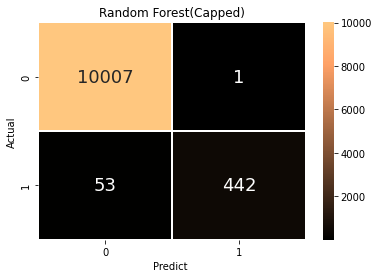

In [321]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_treated_capping_x = df_treated_capping.iloc[:, 0: len(df_treated_capping.columns)-1]
df_treated_capping_y = df_treated_capping.iloc[:, -1]


for train, test in kfold.split(df_treated_capping_x):
    X_train = df_treated_capping_x.iloc[train]
    Y_train = df_treated_capping_y.iloc[train]
    X_test = df_treated_capping_x.iloc[test]
    Y_test = df_treated_capping_y.iloc[test]


    forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 14, max_depth = 40, class_weight={0:1,1:18}, n_jobs = -1, random_state = 42)
    forest_cimoc.fit(X_train, Y_train)
    y_pred = forest_cimoc.predict(X_test)
    

    expected.extend(Y_test)
    predicted.extend(y_pred)


    
fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_capping_table = result_capping_table.append({'classifiers':forest_cimoc.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)    
    


# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized on the test data:')
C_capped_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_capped_plot, 'Random Forest(Capped)', 'copper')


#### 5.a.2 Confusion Matrix for capping dataframe with 10-fold cross-validation (SVM Classifier)


Confusion matrix of SVM optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     10008
         1.0       0.20      0.35      0.26       495

    accuracy                           0.91     10503
   macro avg       0.59      0.64      0.60     10503
weighted avg       0.93      0.91      0.92     10503



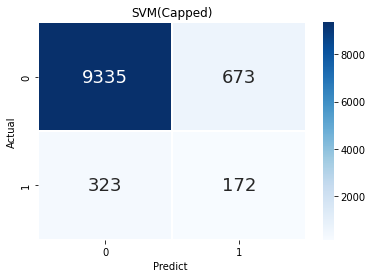

In [322]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_treated_capping_x = df_treated_capping.iloc[:, 0: len(df_treated_capping.columns)-1]
df_treated_capping_y = df_treated_capping.iloc[:, -1]


for train, test in kfold.split(df_treated_capping_x):
    X_train = df_treated_capping_x.iloc[train]
    Y_train = df_treated_capping_y.iloc[train]
    X_test = df_treated_capping_x.iloc[test]
    Y_test = df_treated_capping_y.iloc[test]

    svm_classifier = SVC(kernel = 'poly', C = 3, degree = 3, class_weight={0:1,1:18}, decision_function_shape ='ovo', random_state = 42)
    svm_classifier.fit(X_train, Y_train)
    y_pred = svm_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_capping_table = result_capping_table.append({'classifiers':svm_classifier.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)      
    
    

# Confusion matrix on the test data.
print('\nConfusion matrix of SVM optimized on the test data:')
C_capped_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_capped_plot, 'SVM(Capped)', plt.cm.Blues)

#### 5.a.3 Confusion Matrix for capping dataframe with 10-fold cross-validation (Logist Regression Classifier)


Confusion matrix of Logistic Regression optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88     10008
         1.0       0.15      0.75      0.25       495

    accuracy                           0.79     10503
   macro avg       0.57      0.77      0.56     10503
weighted avg       0.95      0.79      0.85     10503



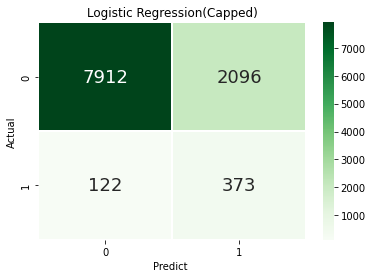

In [323]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_treated_capping_x = df_treated_capping.iloc[:, 0: len(df_treated_capping.columns)-1]
df_treated_capping_y = df_treated_capping.iloc[:, -1]


for train, test in kfold.split(df_treated_capping_x):
    X_train = df_treated_capping_x.iloc[train]
    Y_train = df_treated_capping_y.iloc[train]
    X_test = df_treated_capping_x.iloc[test]
    Y_test = df_treated_capping_y.iloc[test]

    lr_classifier = LogisticRegression(solver = 'liblinear', C = 2, penalty = 'l2', class_weight = {0:1,1:18}, random_state = 42)
    lr_classifier.fit(X_train, Y_train)
    y_pred = lr_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_capping_table = result_capping_table.append({'classifiers':lr_classifier.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)      
    
    

# Confusion matrix on the test data.
print('\nConfusion matrix of Logistic Regression optimized on the test data:')
C_capped_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_capped_plot, 'Logistic Regression(Capped)', plt.cm.Greens)

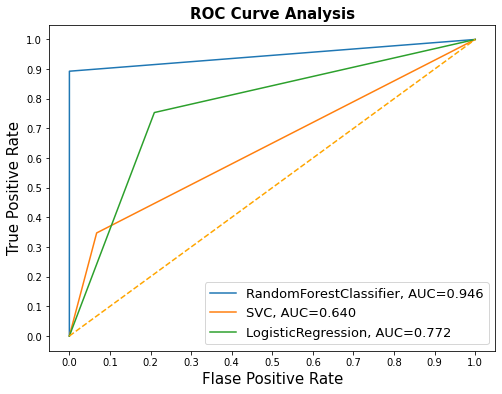

In [324]:
# Set name of the classifiers as index labels
result_capping_table.set_index('classifiers', inplace=True)
plot_AUC_curve(result_capping_table)

### 5.b Feature Selection for anomaly removed dataframe

In [325]:
#Feature selection for anomaly removed data
train_result_anomaly = RF_FeatureSelector(x_TA_train, x_TA_test, y_TA_train, y_TA_test)
anomaly_results = pd.DataFrame(train_result_anomaly, columns=['weight','predictors','recall','predictor_names'])
anomaly_results

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning:

,weight,predictors,recall,predictor_names
0,1,14,0.66,"[Attr5, Attr21, Attr24, Attr26, Attr27, Attr34..."
1,2,14,0.65,"[Attr5, Attr15, Attr16, Attr21, Attr24, Attr25..."
2,3,15,0.63,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
3,4,16,0.65,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."
4,5,14,0.64,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."
5,6,15,0.62,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."
6,7,13,0.64,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."
7,8,13,0.63,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."
8,9,13,0.63,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."
9,10,13,0.63,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."


In [326]:
print("The proposed predictors to be used, based on RFC, are: ",anomaly_results.iloc[11,3].tolist())
print("This is done with a weight of: ",anomaly_results.iloc[11,0])
print("Recall is ",anomaly_results.iloc[11,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr5', 'Attr13', 'Attr16', 'Attr21', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr34', 'Attr38', 'Attr45', 'Attr46', 'Attr58']
This is done with a weight of:  12
Recall is  0.62


In [327]:
result_anomaly_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#### 5.b.1 Confusion Matrix for anomaly removed dataframe with 10-fold cross-validation (Random Forest Classifier)


Confusion matrix of Random Forest optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      9007
         1.0       0.90      0.18      0.30       445

    accuracy                           0.96      9452
   macro avg       0.93      0.59      0.64      9452
weighted avg       0.96      0.96      0.95      9452



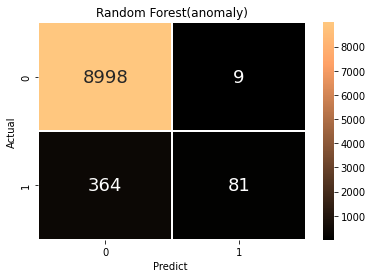

In [328]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_anomaly to do cross-validation 
df_treated_anomaly_x = df_treated_anomaly.iloc[:, 0: len(df_treated_anomaly.columns)-1]
df_treated_anomaly_y = df_treated_anomaly.iloc[:, -1]

for train, test in kfold.split(df_treated_anomaly_x):
    X_train = df_treated_anomaly_x.iloc[train]
    Y_train = df_treated_anomaly_y.iloc[train]
    X_test = df_treated_anomaly_x.iloc[test]
    Y_test = df_treated_anomaly_y.iloc[test]
    
    forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 13, max_depth = 40, class_weight={0:1,1:12}, n_jobs = -1, random_state = 42)
    forest_cimoc.fit(X_train, Y_train)
    y_pred = forest_cimoc.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_anomaly_table = result_anomaly_table.append({'classifiers':forest_cimoc.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)  
    
# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized on the test data:')
C_anomaly_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_anomaly_plot, 'Random Forest(anomaly)', 'copper')


#### 5.a.2 Confusion Matrix for anomaly removed dataframe with 10-fold cross-validation (SVM Classifier)

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\skl


Confusion matrix of SVM optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.95      0.50      0.66      9007
         1.0       0.05      0.51      0.09       445

    accuracy                           0.50      9452
   macro avg       0.50      0.51      0.37      9452
weighted avg       0.91      0.50      0.63      9452



C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


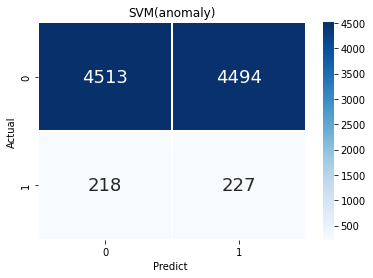

In [329]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_treated_anomaly_x = df_treated_anomaly.iloc[:, 0: len(df_treated_anomaly.columns)-1]
df_treated_anomaly_y = df_treated_anomaly.iloc[:, -1]


for train, test in kfold.split(df_treated_anomaly_x):
    X_train = df_treated_anomaly_x.iloc[train]
    Y_train = df_treated_anomaly_y.iloc[train]
    X_test = df_treated_anomaly_x.iloc[test]
    Y_test = df_treated_anomaly_y.iloc[test]

    svm_classifier = SVC(kernel = 'poly', C = 3, degree = 3, class_weight={0:1,1:12}, decision_function_shape ='ovo', max_iter = 100000,random_state = 42)
    svm_classifier.fit(X_train, Y_train)
    y_pred = svm_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

    
fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_anomaly_table = result_anomaly_table.append({'classifiers':svm_classifier.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)

    
# Confusion matrix on the test data.
print('\nConfusion matrix of SVM optimized on the test data:')
C_anomaly_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_anomaly_plot, 'SVM(anomaly)', plt.cm.Blues)

#### 5.b.3 Confusion Matrix for anomaly removed dataframe with 10-fold cross-validation (Logist Regression Classifier)

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_


Confusion matrix of Logistic Regression optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      9007
         1.0       0.12      0.24      0.16       445

    accuracy                           0.88      9452
   macro avg       0.54      0.58      0.55      9452
weighted avg       0.92      0.88      0.90      9452



C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


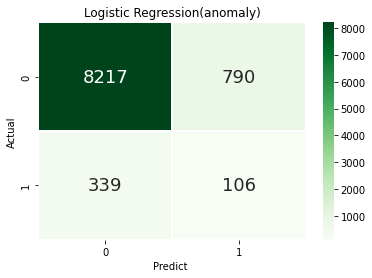

In [330]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_treated_anomaly_x = df_treated_anomaly.iloc[:, 0: len(df_treated_anomaly.columns)-1]
df_treated_anomaly_y = df_treated_anomaly.iloc[:, -1]


for train, test in kfold.split(df_treated_anomaly_x):
    X_train = df_treated_anomaly_x.iloc[train]
    Y_train = df_treated_anomaly_y.iloc[train]
    X_test = df_treated_anomaly_x.iloc[test]
    Y_test = df_treated_anomaly_y.iloc[test]

    lr_classifier = LogisticRegression(solver = 'liblinear', C = 2, penalty = 'l2', class_weight = {0:1,1:12}, random_state = 42)
    lr_classifier.fit(X_train, Y_train)
    y_pred = lr_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_anomaly_table = result_anomaly_table.append({'classifiers':lr_classifier.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)      
    
    

# Confusion matrix on the test data.
print('\nConfusion matrix of Logistic Regression optimized on the test data:')
C_anomaly_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_anomaly_plot, 'Logistic Regression(anomaly)', plt.cm.Greens)

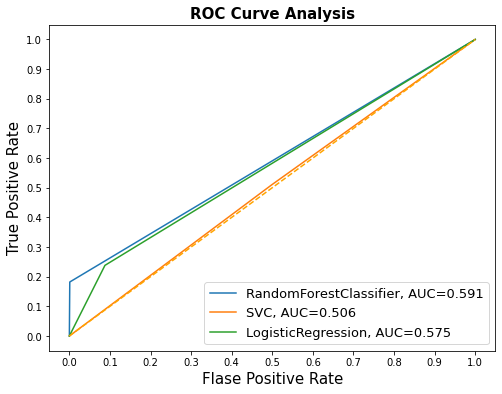

In [331]:
result_anomaly_table.set_index('classifiers', inplace=True)
plot_AUC_curve(result_anomaly_table)

### 5.c Feature Selection for IQR treated dataframe

In [332]:
# Feature Selection for IQR treated dataframe
train_result_IQR = RF_FeatureSelector(x_TIQR_train, x_TIQR_test, y_TIQR_train, y_TIQR_test)
IQR_results = pd.DataFrame(train_result_IQR, columns=['weight','predictors','recall','predictor_names'])
IQR_results

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning:

,weight,predictors,recall,predictor_names
0,1,15,0.93,"[Attr6, Attr15, Attr20, Attr23, Attr27, Attr30..."
1,2,10,0.92,"[Attr6, Attr15, Attr20, Attr23, Attr27, Attr39..."
2,3,10,0.88,"[Attr6, Attr15, Attr20, Attr24, Attr26, Attr27..."
3,4,9,0.87,"[Attr15, Attr20, Attr24, Attr26, Attr27, Attr4..."
4,5,10,0.87,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
5,6,9,0.87,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
6,7,9,0.86,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
7,8,9,0.87,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
8,9,9,0.84,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
9,10,9,0.83,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."


In [333]:
print("The proposed predictors to be used, based on RFC, are: ",IQR_results.iloc[0,3].tolist())
print("This is done with a weight of: ",IQR_results.iloc[0,0])
print("Recall is ",IQR_results.iloc[0,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr6', 'Attr15', 'Attr20', 'Attr23', 'Attr27', 'Attr30', 'Attr32', 'Attr35', 'Attr39', 'Attr41', 'Attr45', 'Attr51', 'Attr57', 'Attr59', 'Attr61']
This is done with a weight of:  1
Recall is  0.93


In [334]:
result_IQR_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#### 5.c.1 Confusion Matrix for  IQR treated dataframe with 10-fold cross-validation (Random Forest classifier)


Confusion matrix of Random Forest optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     10008
         1.0       0.99      0.82      0.90       495

    accuracy                           0.99     10503
   macro avg       0.99      0.91      0.95     10503
weighted avg       0.99      0.99      0.99     10503



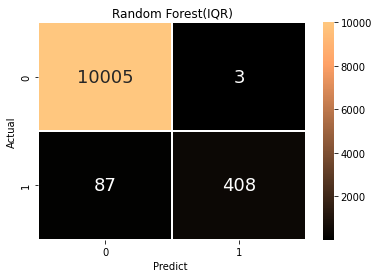

In [335]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_IQR to do cross-validation 
df_treated_IQR_x = df_treated_IQR.iloc[:, 0: len(df_treated_IQR.columns)-1]
df_treated_IQR_y = df_treated_IQR.iloc[:, -1]

for train, test in kfold.split(df_treated_IQR_x):
    X_train = df_treated_IQR_x.iloc[train]
    Y_train = df_treated_IQR_y.iloc[train]
    X_test = df_treated_IQR_x.iloc[test]
    Y_test = df_treated_IQR_y.iloc[test]

    forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 15, max_depth = 40, class_weight={0:1,1:1}, n_jobs = -1, random_state = 42)
    forest_cimoc.fit(X_train, Y_train)
    y_pred = forest_cimoc.predict(X_test)
    
    expected.extend(Y_test)
    predicted.extend(y_pred)

    
fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_IQR_table = result_IQR_table.append({'classifiers':forest_cimoc.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)
    

# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized on the test data:')
C_IQR_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_IQR_plot, 'Random Forest(IQR)', 'copper')

#### 5.c.2 Confusion Matrix for IQR treated  dataframe with 10-fold cross-validation (SVM Classifier)

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\skl


Confusion matrix of SVM optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     10008
         1.0       1.00      0.01      0.01       495

    accuracy                           0.95     10503
   macro avg       0.98      0.50      0.49     10503
weighted avg       0.96      0.95      0.93     10503



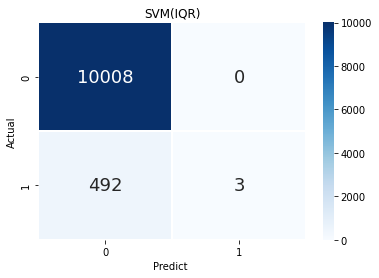

In [336]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_treated_IQR_x = df_treated_IQR.iloc[:, 0: len(df_treated_IQR.columns)-1]
df_treated_IQR_y = df_treated_IQR.iloc[:, -1]


for train, test in kfold.split(df_treated_IQR_x):
    X_train = df_treated_IQR_x.iloc[train]
    Y_train = df_treated_IQR_y.iloc[train]
    X_test = df_treated_IQR_x.iloc[test]
    Y_test = df_treated_IQR_y.iloc[test]

    svm_classifier = SVC(kernel = 'poly', C = 3, degree = 3, gamma = 'scale', class_weight={0:1,1:1}, decision_function_shape ='ovo', max_iter = 100000, random_state = 42)
    svm_classifier.fit(X_train, Y_train)
    y_pred = svm_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_IQR_table = result_IQR_table.append({'classifiers':svm_classifier.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)


# Confusion matrix on the test data.
print('\nConfusion matrix of SVM optimized on the test data:')
C_IQR_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_IQR_plot, 'SVM(IQR)', plt.cm.Blues)

#### 5.c.3 Confusion Matrix for IQR treated removed dataframe with 10-fold cross-validation (Logist Regression Classifier)


Confusion matrix of Logistic Regression optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     10008
         1.0       0.72      0.07      0.13       495

    accuracy                           0.95     10503
   macro avg       0.84      0.54      0.55     10503
weighted avg       0.94      0.95      0.94     10503



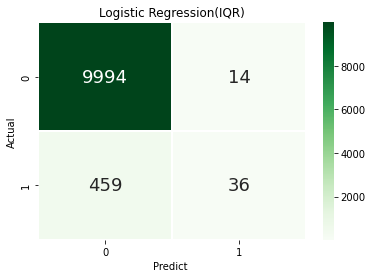

In [337]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_treated_IQR_x = df_treated_IQR.iloc[:, 0: len(df_treated_IQR.columns)-1]
df_treated_IQR_y = df_treated_IQR.iloc[:, -1]


for train, test in kfold.split(df_treated_IQR_x):
    X_train = df_treated_IQR_x.iloc[train]
    Y_train = df_treated_IQR_y.iloc[train]
    X_test = df_treated_IQR_x.iloc[test]
    Y_test = df_treated_IQR_y.iloc[test]

    lr_classifier = LogisticRegression(solver = 'liblinear', C = 2, penalty = 'l2', class_weight = {0:1,1:1}, random_state = 42)
    lr_classifier.fit(X_train, Y_train)
    y_pred = lr_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_IQR_table = result_IQR_table.append({'classifiers':lr_classifier.__class__.__name__,
                                                    'fpr':fpr, 
                                                    'tpr':tpr, 
                                                    'auc':auc}, ignore_index=True)      
    
    

# Confusion matrix on the test data.
print('\nConfusion matrix of Logistic Regression optimized on the test data:')
C_anomaly_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_anomaly_plot, 'Logistic Regression(IQR)', plt.cm.Greens)

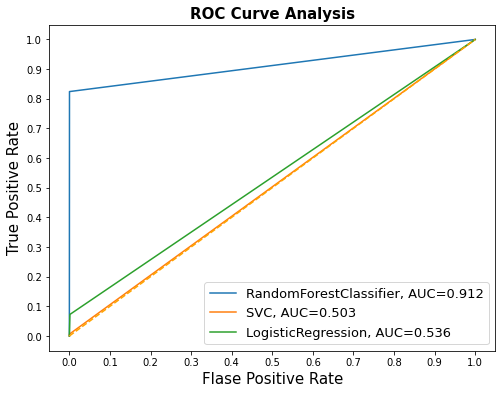

In [338]:
# Set name of the classifiers as index labels
result_IQR_table.set_index('classifiers', inplace=True) 
plot_AUC_curve(result_IQR_table)

### 5.d Feature Selection for median imputed dataframe

In [339]:
# Feature Selection for Median Imputed dataframe
train_result_MI = RF_FeatureSelector(x_MI_train, x_MI_test, y_MI_train, y_MI_test)
MI_results = pd.DataFrame(train_result_MI, columns=['weight','predictors','recall','predictor_names'])
MI_results

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\base.py:438: UserWarning:

,weight,predictors,recall,predictor_names
0,1,17,0.64,"[Attr5, Attr15, Attr20, Attr21, Attr24, Attr26..."
1,2,17,0.65,"[Attr5, Attr15, Attr20, Attr21, Attr24, Attr26..."
2,3,15,0.66,"[Attr5, Attr15, Attr20, Attr21, Attr24, Attr26..."
3,4,12,0.65,"[Attr5, Attr15, Attr20, Attr21, Attr24, Attr26..."
4,5,12,0.65,"[Attr5, Attr15, Attr21, Attr24, Attr26, Attr27..."
5,6,10,0.64,"[Attr5, Attr16, Attr21, Attr24, Attr26, Attr27..."
6,7,10,0.65,"[Attr5, Attr16, Attr21, Attr24, Attr26, Attr27..."
7,8,11,0.66,"[Attr5, Attr16, Attr21, Attr24, Attr26, Attr27..."
8,9,12,0.66,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr26..."
9,10,10,0.66,"[Attr5, Attr16, Attr21, Attr24, Attr26, Attr27..."


In [340]:
print("The proposed predictors to be used, based on RFC, are: ",MI_results.iloc[7,3].tolist())
print("This is done with a weight of: ",MI_results.iloc[7,0])
print("Recall is ",MI_results.iloc[7,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr5', 'Attr16', 'Attr21', 'Attr24', 'Attr26', 'Attr27', 'Attr29', 'Attr34', 'Attr45', 'Attr46', 'Attr58']
This is done with a weight of:  8
Recall is  0.66


In [357]:
result_MI_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

#### 5.d.1 Confusion Matrix for  median imputed dataframe with 10-fold cross-validation (Random Forest Classifier)


Confusion matrix of Random Forest optimized for Recall on the test data:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     10008
         1.0       0.83      0.15      0.25       495

    accuracy                           0.96     10503
   macro avg       0.90      0.57      0.62     10503
weighted avg       0.95      0.96      0.94     10503



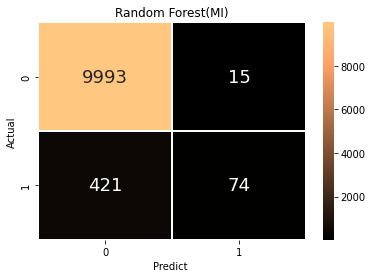

In [358]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_median_imputed to do cross-validation 
df_median_imputed_x = df_median_imputed.iloc[:, 0: len(df_median_imputed.columns)-1]
df_median_imputed_y = df_median_imputed.iloc[:, -1]

for train, test in kfold.split(df_median_imputed_x):

    X_train = df_median_imputed_x.iloc[train]
    Y_train = df_median_imputed_y.iloc[train]
    X_test = df_median_imputed_x.iloc[test]
    Y_test = df_median_imputed_y.iloc[test]
    
    forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 11, max_depth = 40, class_weight={0:1,1:8}, n_jobs = 1, random_state = 42)
    forest_cimoc.fit(X_train, Y_train)
    y_pred = forest_cimoc.predict(X_test)
    
    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_MI_table = result_MI_table.append({'classifiers':forest_cimoc.__class__.__name__,
                                          'fpr':fpr, 
                                          'tpr':tpr, 
                                          'auc':auc}, ignore_index=True)    
    

# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for Recall on the test data:')
C_MI_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_MI_plot, 'Random Forest(MI)', 'copper')

#### 5.d.2 Confusion Matrix for median imputed dataframe with 10-fold cross-validation (SVM Classifier)

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\skl


Confusion matrix of SVM optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.95      0.60      0.74     10008
         1.0       0.05      0.41      0.09       495

    accuracy                           0.59     10503
   macro avg       0.50      0.50      0.41     10503
weighted avg       0.91      0.59      0.71     10503



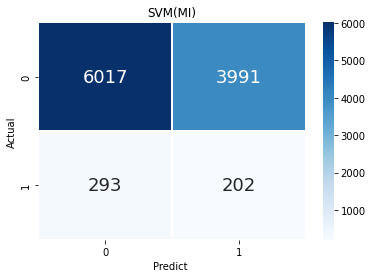

In [359]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_median_imputed_x = df_median_imputed.iloc[:, 0: len(df_median_imputed.columns)-1]
df_median_imputed_y = df_median_imputed.iloc[:, -1]


for train, test in kfold.split(df_median_imputed_x):
    X_train = df_median_imputed_x.iloc[train]
    Y_train = df_median_imputed_y.iloc[train]
    X_test = df_median_imputed_x.iloc[test]
    Y_test = df_median_imputed_y.iloc[test]

    svm_classifier = SVC(kernel = 'poly', C = 3, degree = 3, gamma = 'scale', class_weight={0:1,1:8}, decision_function_shape ='ovo', max_iter = 100000, random_state = 42)
    svm_classifier.fit(X_train, Y_train)
    y_pred = svm_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

    
fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_MI_table = result_MI_table.append({'classifiers':svm_classifier.__class__.__name__,
                                          'fpr':fpr, 
                                          'tpr':tpr, 
                                          'auc':auc}, ignore_index=True)    
    

# Confusion matrix on the test data.
print('\nConfusion matrix of SVM optimized on the test data:')
C_MI_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_MI_plot, 'SVM(MI)', plt.cm.Blues)

#### 5.d.3 Confusion Matrix for median imputed dataframe with 10-fold cross-validation (Logist Regression Classifier)

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_


Confusion matrix of Logistic Regression optimized on the test data:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     10008
         1.0       0.03      0.01      0.02       495

    accuracy                           0.93     10503
   macro avg       0.49      0.50      0.49     10503
weighted avg       0.91      0.93      0.92     10503



C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


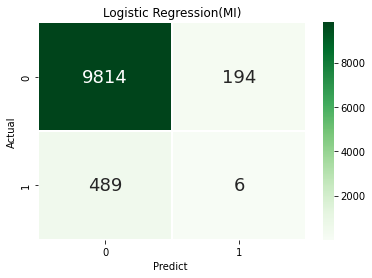

In [360]:
predicted = []
expected = []

X_train =[]
Y_train =[]
X_test =[]
Y_test = []

# use df_treated_capping to do cross-validation 
df_median_imputed_x = df_median_imputed.iloc[:, 0: len(df_median_imputed.columns)-1]
df_median_imputed_y = df_median_imputed.iloc[:, -1]


for train, test in kfold.split(df_median_imputed_x):
    X_train = df_median_imputed_x.iloc[train]
    Y_train = df_median_imputed_y.iloc[train]
    X_test = df_median_imputed_x.iloc[test]
    Y_test = df_median_imputed_y.iloc[test]

    lr_classifier = LogisticRegression(solver = 'liblinear', C = 2, penalty = 'l2', class_weight = {0:1,1:8}, random_state = 42)
    lr_classifier.fit(X_train, Y_train)
    y_pred = lr_classifier.predict(X_test)

    expected.extend(Y_test)
    predicted.extend(y_pred)

fpr, tpr, _ = roc_curve(expected,  predicted)
auc = roc_auc_score(expected, predicted)
    
result_MI_table = result_MI_table.append({'classifiers':lr_classifier.__class__.__name__,
                                          'fpr':fpr, 
                                          'tpr':tpr, 
                                          'auc':auc}, ignore_index=True)      
    
    

# Confusion matrix on the test data.
print('\nConfusion matrix of Logistic Regression optimized on the test data:')
C_MI_plot = confusion_matrix(expected, predicted) 

print(classification_report(expected, predicted))
plot_confusion_matrix(C_MI_plot, 'Logistic Regression(MI)', plt.cm.Greens)

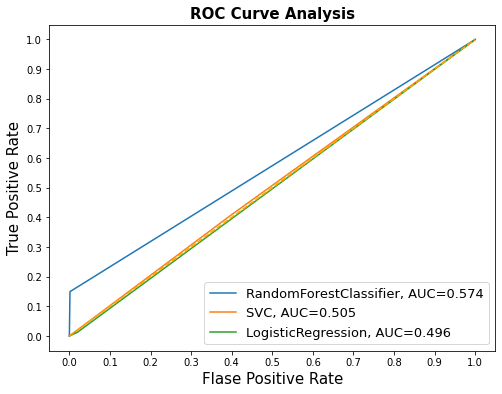

In [361]:
# Set name of the classifiers as index labels
result_MI_table.set_index('classifiers', inplace=True) 
plot_AUC_curve(result_MI_table)

From above four methods of imputation in <b>Random Forest Classifier</b>, the performance of the classifiers is ranked from best to worst:<br>

<b>1. capping</b><br>
<b>2. IQR</b><br>
<b>3. anomaly</b><br>
<b>4. midean imputed

## 6. Hyper Parameter Tuning (rfc, svm, lr)

From above demonstration, we will choose `capping dataframe` as one of tunning conditions which means `class_weight = {0:1, 1:18}`, since it has good performance.

In [362]:
# Attribution setting
_cv = StratifiedKFold(n_splits = 3)

experiment_list = [
    {
        "name": "SVM",
        "classifier": SVC,
        "params": {
            "random_state": [42],
            "C":[0.01, 0.1, 1.0, 3.0, 5.0],
            "kernel":['rbf','poly'],
            "class_weight" : [{0:1,1:18}, 'balanced'],
            "decision_function_shape" :['ovo'],
            "max_iter" : [100000]
        },
    },
    
    {
        "name": "Random Forest",
        "classifier": RandomForestClassifier,
        "params": {
            "random_state": [42],
            "criterion": ["gini", "entropy"],
            "n_estimators" : [50, 100, 200, 300],
            "max_depth": [10, 20, 30, 40, 50],
            "min_samples_leaf": [5, 10, 20],
            "class_weight" : [{0:1,1:18}, 'balanced'],
            "n_jobs": [-1]
        },
    },
    
    {
        "name": "Logistic Regression",
        "classifier": LogisticRegression,
        "params": {
            "random_state": [42],
            "C": [0.01, 0.1, 1.0, 3.0, 5.0, 10.0, 50.0],
            "class_weight": [{0:1,1:18}, 'balanced'],
            "solver": ['liblinear', 'auto', 'sqrt', 'log2'],
            "n_jobs":[-1]
        },
    
    }
    
]


In [363]:
def run_experiments(X_train, y_train, X_test, y_test, scoring="recall"):
    for experiment in experiment_list:
        print(f'****{experiment["name"]}****')

        grid = GridSearchCV(experiment["classifier"](),
                            experiment["params"],
                            cv=_cv,
                            scoring = scoring,
                            refit = "recall",
                            n_jobs=-1,
                            return_train_score=True,
        )
        
        
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
        print("Best score:")
        print(grid.best_score_)
        print("Best params:")
        print(grid.best_params_)

        print("\n")
        
        print(classification_report(y_test, y_pred))

In [364]:
run_experiments(x_TC_train, y_TC_train, x_TC_test, y_TC_test)

****SVM****
Best score:
1.0
Best params:
{'C': 0.01, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'kernel': 'poly', 'max_iter': 100000, 'random_state': 42}


              precision    recall  f1-score   support

         0.0       1.00      0.21      0.34      2002
         1.0       0.06      1.00      0.11        99

    accuracy                           0.25      2101
   macro avg       0.53      0.60      0.23      2101
weighted avg       0.96      0.25      0.33      2101

****Random Forest****
Best score:
0.9848484848484849
Best params:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}


              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      2002
         1.0       0.57      1.00      0.73        99

    accuracy                           0.96      2101
   macro avg       0.79      0.98      0.85      2101
weighted 

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
126 fits failed out of a total of 168.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\linear_model\_logistic.

Best score:
0.7803030303030303
Best params:
{'C': 0.1, 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42, 'solver': 'liblinear'}


              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83      2002
         1.0       0.12      0.80      0.21        99

    accuracy                           0.72      2101
   macro avg       0.55      0.76      0.52      2101
weighted avg       0.95      0.72      0.80      2101



## 7. Conclusion

By comparing performance metrics, we can see that`Random Forest Classifier` has the highest accuracy, precision, f1 scores, best roc_auc curve and a high marco recall rate of 0.98 (the metric we value the most) after tunning parameters, becoming the best classifier for predicting bankruptcy. `Logistic Regression Classifier` and `Support Vector Machine Classifier` perform secondly as well. It proves that trees work best with imbalanced data.